# Lesson 33: Review of exercise 4

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](e04.ipynb).*

In [56]:
import glob
import re

import numpy as np
import pandas as pd
import numba

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Exercise 4.1: Long-term trends in hybridization of Darwin finches

[Peter and Rosemary Grant](https://en.wikipedia.org/wiki/Peter_and_Rosemary_Grant) have been working on the Galápagos island of Daphne Major for over forty years.  During this time, they have collected lots and lots of data about physiological features of finches.  Last year, they published a book with a summary of some of their major results (Grant P. R., Grant B. R., *Data from: 40 years of evolution. Darwin's finches on Daphne Major Island*, Princeton University Press, 2014). They made their data from the book publicly available via the [Dryad Digital Repository](http://dx.doi.org/10.5061/dryad.g6g3h).


We will investigate their measurements of beak depth (the distance, top to bottom, of a closed beak) and beak length (base to tip on the top) of Darwin's finches.  We will look at data from two species, *Geospiza fortis* and *Geospiza scandens*.  The Grants provided data on the finches of Daphne for the years 1973, 1975, 1987, 1991, and 2012.  I have included the data in the files `grant_1973.csv`, `grant_1975.csv`, `grant_1987.csv`, `grant_1991.csv`, and  `grant_2012.csv`. They are in almost exactly the same format is in the Dryad repository; I have only deleted blank entries at the end of the files.

**Note**: If you want to skip the munging (which is very valuable experience), you can go directly to part (d). You can load in the `DataFrame` you generate in parts (a) through (c) from the file `~/git/bootcamp/data/grant_complete.csv`.

**a)** Load each of the files into separate Pandas `DataFrame`s.  You might want to inspect the file first to make sure you know what character the comments start with and if there is a header row.

**b)** We would like to merge these all into one `DataFrame`.  The problem is that they have different header names, and only the 1973 file has a year entry (called `yearband`).  This is common with real data.  It is often a bit messy and requires some munging.  

>1. First, change the name of the `yearband` column of the 1973 data to `year`.  Also, make sure the year format is four digits, not two!  
>2. Next, add a `year` column to the other four `DataFrame`s.  You want tidy data, so each row in the `DataFrame` should have an entry for the year.
>3. Change the column names so that all the `DataFrame`s have the same column names.  I would choose column names
>
>    `['band', 'species', 'beak length (mm)', 'beak depth (mm)', 'year']`
>
>4. Concatenate the `DataFrame`s into a single `DataFrame`. Be careful with indices! If you use `pd.concat()`, you will need to use the `ignore_index=True` kwarg. You might also need to use the `axis` kwarg.

**c)** The `band` fields gives the number of the band on the bird's leg that was used to tag it.  Are some birds counted twice?  Are they counted twice in the same year?  Do you think you should drop duplicate birds from the same year?  How about different years?  My opinion is that you should drop duplicate birds from the same year and keep the others, but I would be open to discussion on that.  To practice your Pandas skills, though, let's delete only duplicate birds from the same year from the `DataFrame`.  When you have made this `DataFrame`, save it as a CSV file.

*Hint*: The `DataFrame` methods `duplicated()` and `drop_duplicates()` will be useful.

After doing this work, it is worth saving your tidy `DataFrame` in a CSV document. To this using the `to_csv()` method of your `DataFrame`. Since the indices are uninformative, you should use the `index=False` kwarg. (I have already done this and saved it as `~/git/bootcamp/data/grant_complete.csv`, which will help you do the rest of the exercise if you have problems with this part.)

**d)** Plot an ECDF of beak depths of *Geospiza fortis* specimens measured in 1987.  Plot an ECDF of the beak depths of *Geospiza scandens* from the same year.  These ECDFs should be on the same plot.  On another plot, plot ECDFs of beak lengths for the two species in 1987.  Do you see a striking phenotypic difference?

**e)** Perhaps a more informative plot is to plot the measurement of each bird's beak as a point in the beak depth-beak length plane.  For the 1987 data, plot beak depth vs. beak width for *Geospiza fortis* as blue dots, and for *Geospiza scandens* as red dots.  Can you see the species demarcation?

**f)** Do part (e) again for all years.  Describe what you see.  Do you see the changes in the differences between species (presumably as a result of hybridization)?  In your plots, make sure all plots have the same range on the axes.

### Exercise 4.1: solutions

Upon inspecting the files, we see that the comment character is, as usual, `#`.  There is also a header row in each file, as the first row, so they files are pretty standard.  It is important to note that not all of the column headings are the same, but the units of length in the measurements is millimeters.  Let's go ahead and load them in!  We will load them into a list. I will use the `glob` module to load in all the `csv` files with the substring `'grant'`.

In [6]:
# Get list of CSV files
csv_list = glob.glob('data/grant*.csv')

# Initialize list of DataFrames
df_list = []

# Load in each sequentially.
for csv_file in csv_list:
    # Read in DataFrame
    df = pd.read_csv(csv_file, comment='#')
    
    # Place in list
    df_list.append(df)

Let's take a quick look at the first entry in the list, just to make sure it loaded ok.

In [8]:
df_list[0].head()

,band,species,yearband,beak length,beak depth
0,20123,fortis,73,9.25,8.05
1,20126,fortis,73,11.35,10.45
2,20128,fortis,73,10.15,9.55
3,20129,fortis,73,9.95,8.75
4,20133,fortis,73,11.55,10.15


Looks good!

**b)** Before moving on, we need to know what year is associated with each `DataFrame`.  Fortunately, `glob.glob` gives us the result back in order, so we can extract the year from the file names.

In [9]:
# Initialize years
years = []
for csv_file in csv_list:
    years.append(int(csv_file[-8:-4]))

Let's check to make sure we got them!

In [10]:
years

[1973, 1975, 1987, 1991, 2012]

Looks good.  Now, we'll proceed with the steps we need to take to clean things up.  First, we'll change the `'yearband'` column in the `DataFrame` from 1973 to `'year'`, and change its year from `73` to `1973`.

In [12]:
# Rename to year
df_list[0] = df_list[0].rename(columns={'yearband': 'year'})

# No worries about Y2K
df_list[0]['year'] += 1900

# Check it out
df_list[0].head()

,band,species,year,beak length,beak depth
0,20123,fortis,3873,9.25,8.05
1,20126,fortis,3873,11.35,10.45
2,20128,fortis,3873,10.15,9.55
3,20129,fortis,3873,9.95,8.75
4,20133,fortis,3873,11.55,10.15


Great!  Let's proceed to add a `year` column to all of the other `DataFrame`s.  As we do it, we'll just reassign the 1973 year in that `DataFrame`, but that's no big deal.

In [13]:
for i, df in enumerate(df_list):
    df_list[i]['year'] = np.ones(len(df), dtype=int) * years[i]

Let's check one to make sure it makes sense.

In [14]:
df_list[3].head()

,band,species,blength,bdepth,year
0,2639,fortis,10.30,8.95,1991
1,2666,fortis,12.81,9.30,1991
2,2753,fortis,10.89,10.35,1991
3,2776,fortis,11.30,10.00,1991
4,4229,fortis,10.05,8.62,1991


Looks good.  Now, we need to change the column names so they are all the same for the respective `DataFrame`s.  We have few enough `DataFrame`s that we could do that by hand, but it is more instructive (and re-usable) if we automate it.  We will write a function to rename the columns.  It first sniffs out which column should be `'band'`, which should be `'species'`, and so on.  We can do this with Pandas's convenient `.str` methods, which enable us to use string methods on many entries at once.  This is perhaps best seen by example.

In [15]:
# Choose a DataFrame to try it on.
df = df_list[3]

# Look at the columns
df.columns

Index(['band', 'species', 'blength', 'bdepth', 'year'], dtype='object')

Now, if we are interested in the beak length column, we want to find a column heading that contains `'len'`, since pretty much anything that is about beak length would have the substring.  We can use the convenient `str.contains()` method.

In [16]:
# See which column had 'len' in it
df.columns.str.contains('len')

array([False, False,  True, False, False], dtype=bool)

Now, we can slice out the column heading that has `'len'` in it.

In [17]:
df.columns[df.columns.str.contains('len')]

Index(['blength'], dtype='object')

Finally, we just want the string, so we do

In [19]:
df.columns[df.columns.str.contains('len')][0]

'blength'

We'll use this to identify the current column headings and then change them to what we want.

In [20]:
def rename_cols(df):
    """Rename columns so all DataFrames have same column headings."""
    
    # Sniff out the key names from names that are close
    band_key = df.columns[df.columns.str.contains('and')][0]
    species_key = df.columns[df.columns.str.contains('ecies')][0]
    length_key = df.columns[df.columns.str.contains('len')][0]
    depth_key = df.columns[df.columns.str.contains('dep')][0]
    year_key = df.columns[df.columns.str.contains('year')][0]
    
    # Rename the columns using renaming dictionary
    return df.rename(columns={band_key: 'band',
                              species_key: 'species',
                              depth_key: 'beak depth (mm)',
                              length_key: 'beak length (mm)',
                              year_key: 'year'})

Now, we can loop through the `DateFrame`s and rename the columns.

In [21]:
for i, df in enumerate(df_list):
    df_list[i] = rename_cols(df)
    
# Check the result
df_list[3].head()

,band,species,beak length (mm),beak depth (mm),year
0,2639,fortis,10.30,8.95,1991
1,2666,fortis,12.81,9.30,1991
2,2753,fortis,10.89,10.35,1991
3,2776,fortis,11.30,10.00,1991
4,4229,fortis,10.05,8.62,1991


Finally, we do the concatenation using `pd.concat()`.  We want to ignore the indices because they are not important identifiers.

In [22]:
df = pd.concat(df_list, axis=0, ignore_index=True)

# Take a look
df

,band,beak depth (mm),beak length (mm),species,year
0,20123,8.05,9.25,fortis,1973
1,20126,10.45,11.35,fortis,1973
2,20128,9.55,10.15,fortis,1973
3,20129,8.75,9.95,fortis,1973
4,20133,10.15,11.55,fortis,1973
5,20136,9.85,11.15,fortis,1973
6,20138,8.85,10.05,fortis,1973
7,20142,10.15,11.25,fortis,1973
8,20143,8.15,9.15,fortis,1973
9,20146,8.55,9.25,fortis,1973


Great!  We now have one convenient `DataFrame` to work with.

**c)** First, let's look for duplicate band numbers.  There are many, so we'll just write out how many.  The `df.duplicated()` method returns True for each row if it is a duplicate.  We will get all duplicates in the `'band'` column, and then get the unique values in the list of all duplicated.  This will tell us how many birds were measured more than once.

In [23]:
# Stats about how many birds were measured more than once
print('There were', len(df['band'][df['band'].duplicated()].unique()), 
      'birds that were measured more than once.')
print('There were', len(df['band'].unique()), 'total birds measured.')

There were 350 birds that were measured more than once.
There were 1954 total birds measured.


So, most birds were only measured once.  Nonetheless, let's eliminate duplicates of birds that were measured twice.  When we drop the duplicates, we will keep the first measurement.

In [24]:
# Drop all rows with matching year and band (keep first)
df = df.drop_duplicates(subset=['year', 'band'])

Finally, we will save the `DataFrame` as a CSV file using the `df.to_csv()` method.  We do not want to print the indices (they are meaningless).

In [25]:
df.to_csv('data/grant_complete.csv', index=False)

**d)**  Let's just go ahead and generate the plot. You should have your function `ecdf()` in your repository. I will quickly re-write it here.

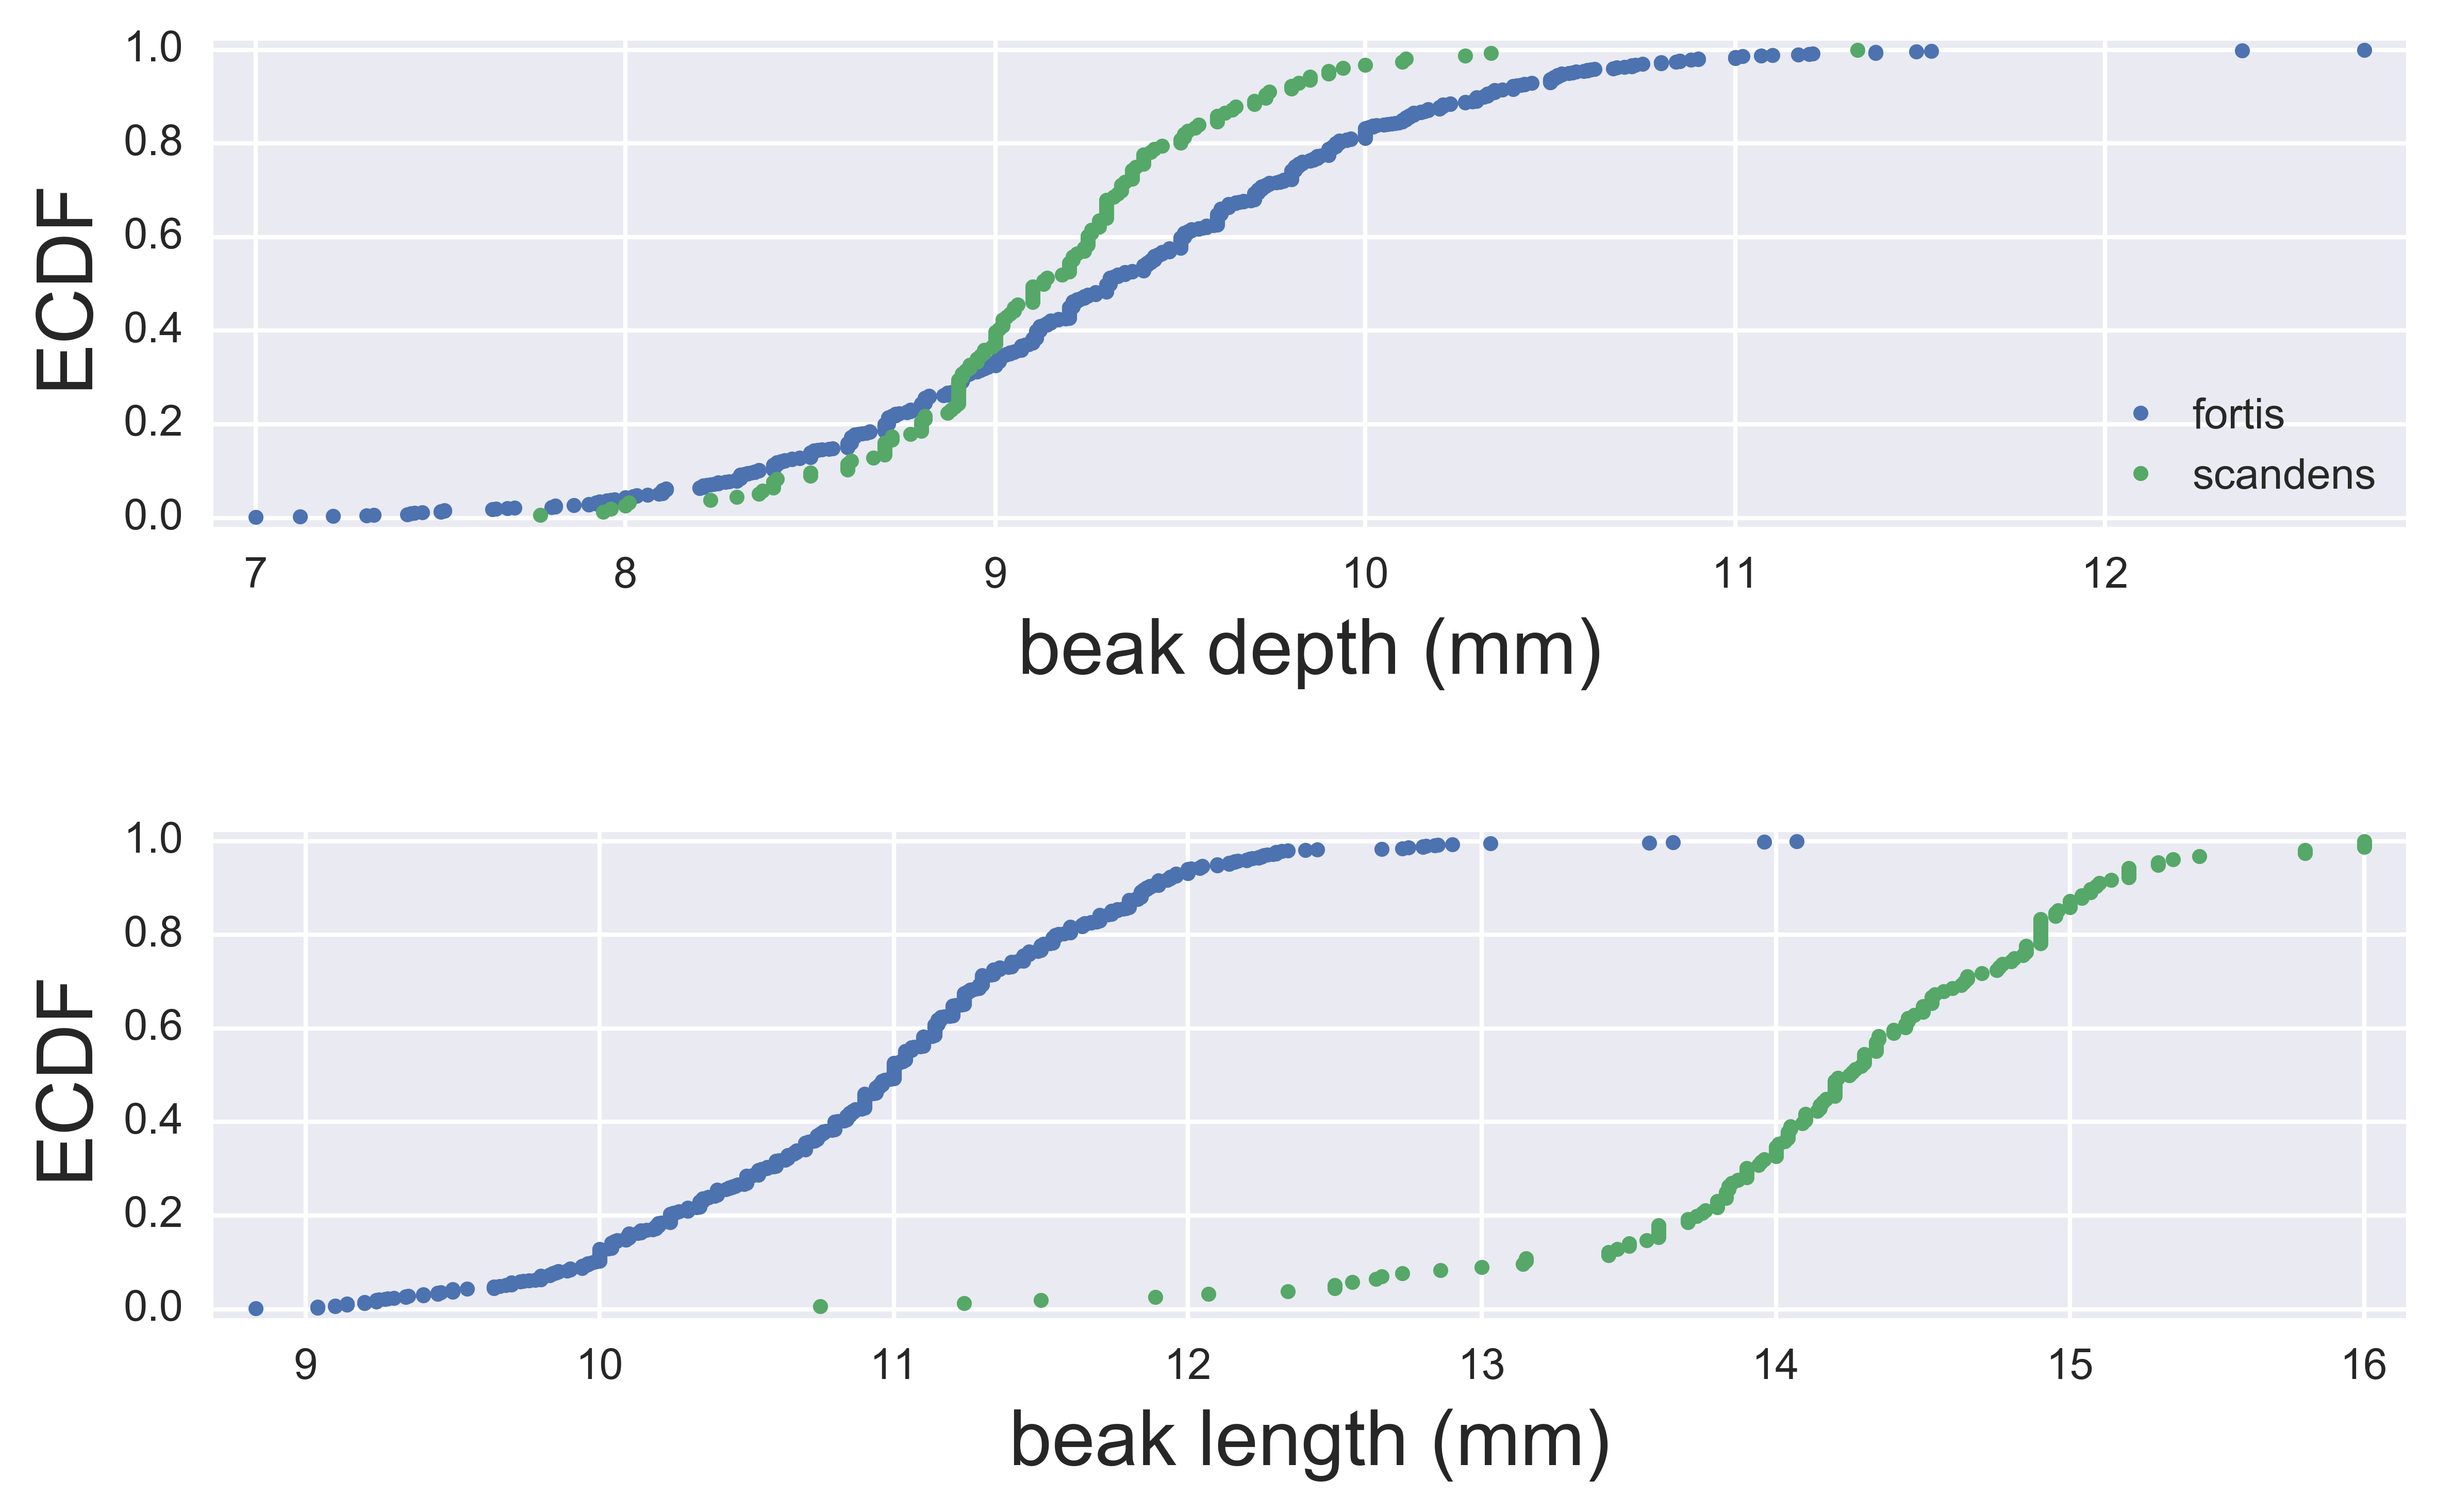

In [32]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Pull out data for ECDF plotting
bd_fortis = \
    df.loc[(df['species']=='fortis') & (df['year']==1987), 'beak depth (mm)']
bd_scandens = \
  df.loc[(df['species']=='scandens') & (df['year']==1987), 'beak depth (mm)']
    
bl_fortis = \
    df.loc[(df['species']=='fortis') & (df['year']==1987), 'beak length (mm)']
bl_scandens = \
  df.loc[(df['species']=='scandens') & (df['year']==1987), 'beak length (mm)']

# Set up figure
fig, ax = plt.subplots(2, 1, figsize=(8, 5))

# Plot beak depth ECDFs
x, y = ecdf(bd_fortis)
ax[0].plot(x, y, marker='.', linestyle='none')
x, y = ecdf(bd_scandens)
ax[0].plot(x, y, marker='.', linestyle='none')
ax[0].margins(0.02)

# Plot beak length ECDFs
x, y = ecdf(bl_fortis)
ax[1].plot(x, y, marker='.', linestyle='none')
x, y = ecdf(bl_scandens)
ax[1].plot(x, y, marker='.', linestyle='none')
ax[1].margins(0.02)

# Legends and axis labels, tidying
ax[0].legend(('fortis', 'scandens'), loc='lower right')
ax[0].set_xlabel('beak depth (mm)')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('ECDF')
ax[1].set_xlabel('beak length (mm)')
fig.tight_layout(h_pad=3)

There is apparently not a strong phenotypic difference in beak depth, though *fortis* tends to have more birds with deep beaks, but there is a striking difference in beak length, with *Geospiza scandens* having longer beaks.

**e)** Now let's make a plot of the 1987 data in the beak depth-beak length plane.

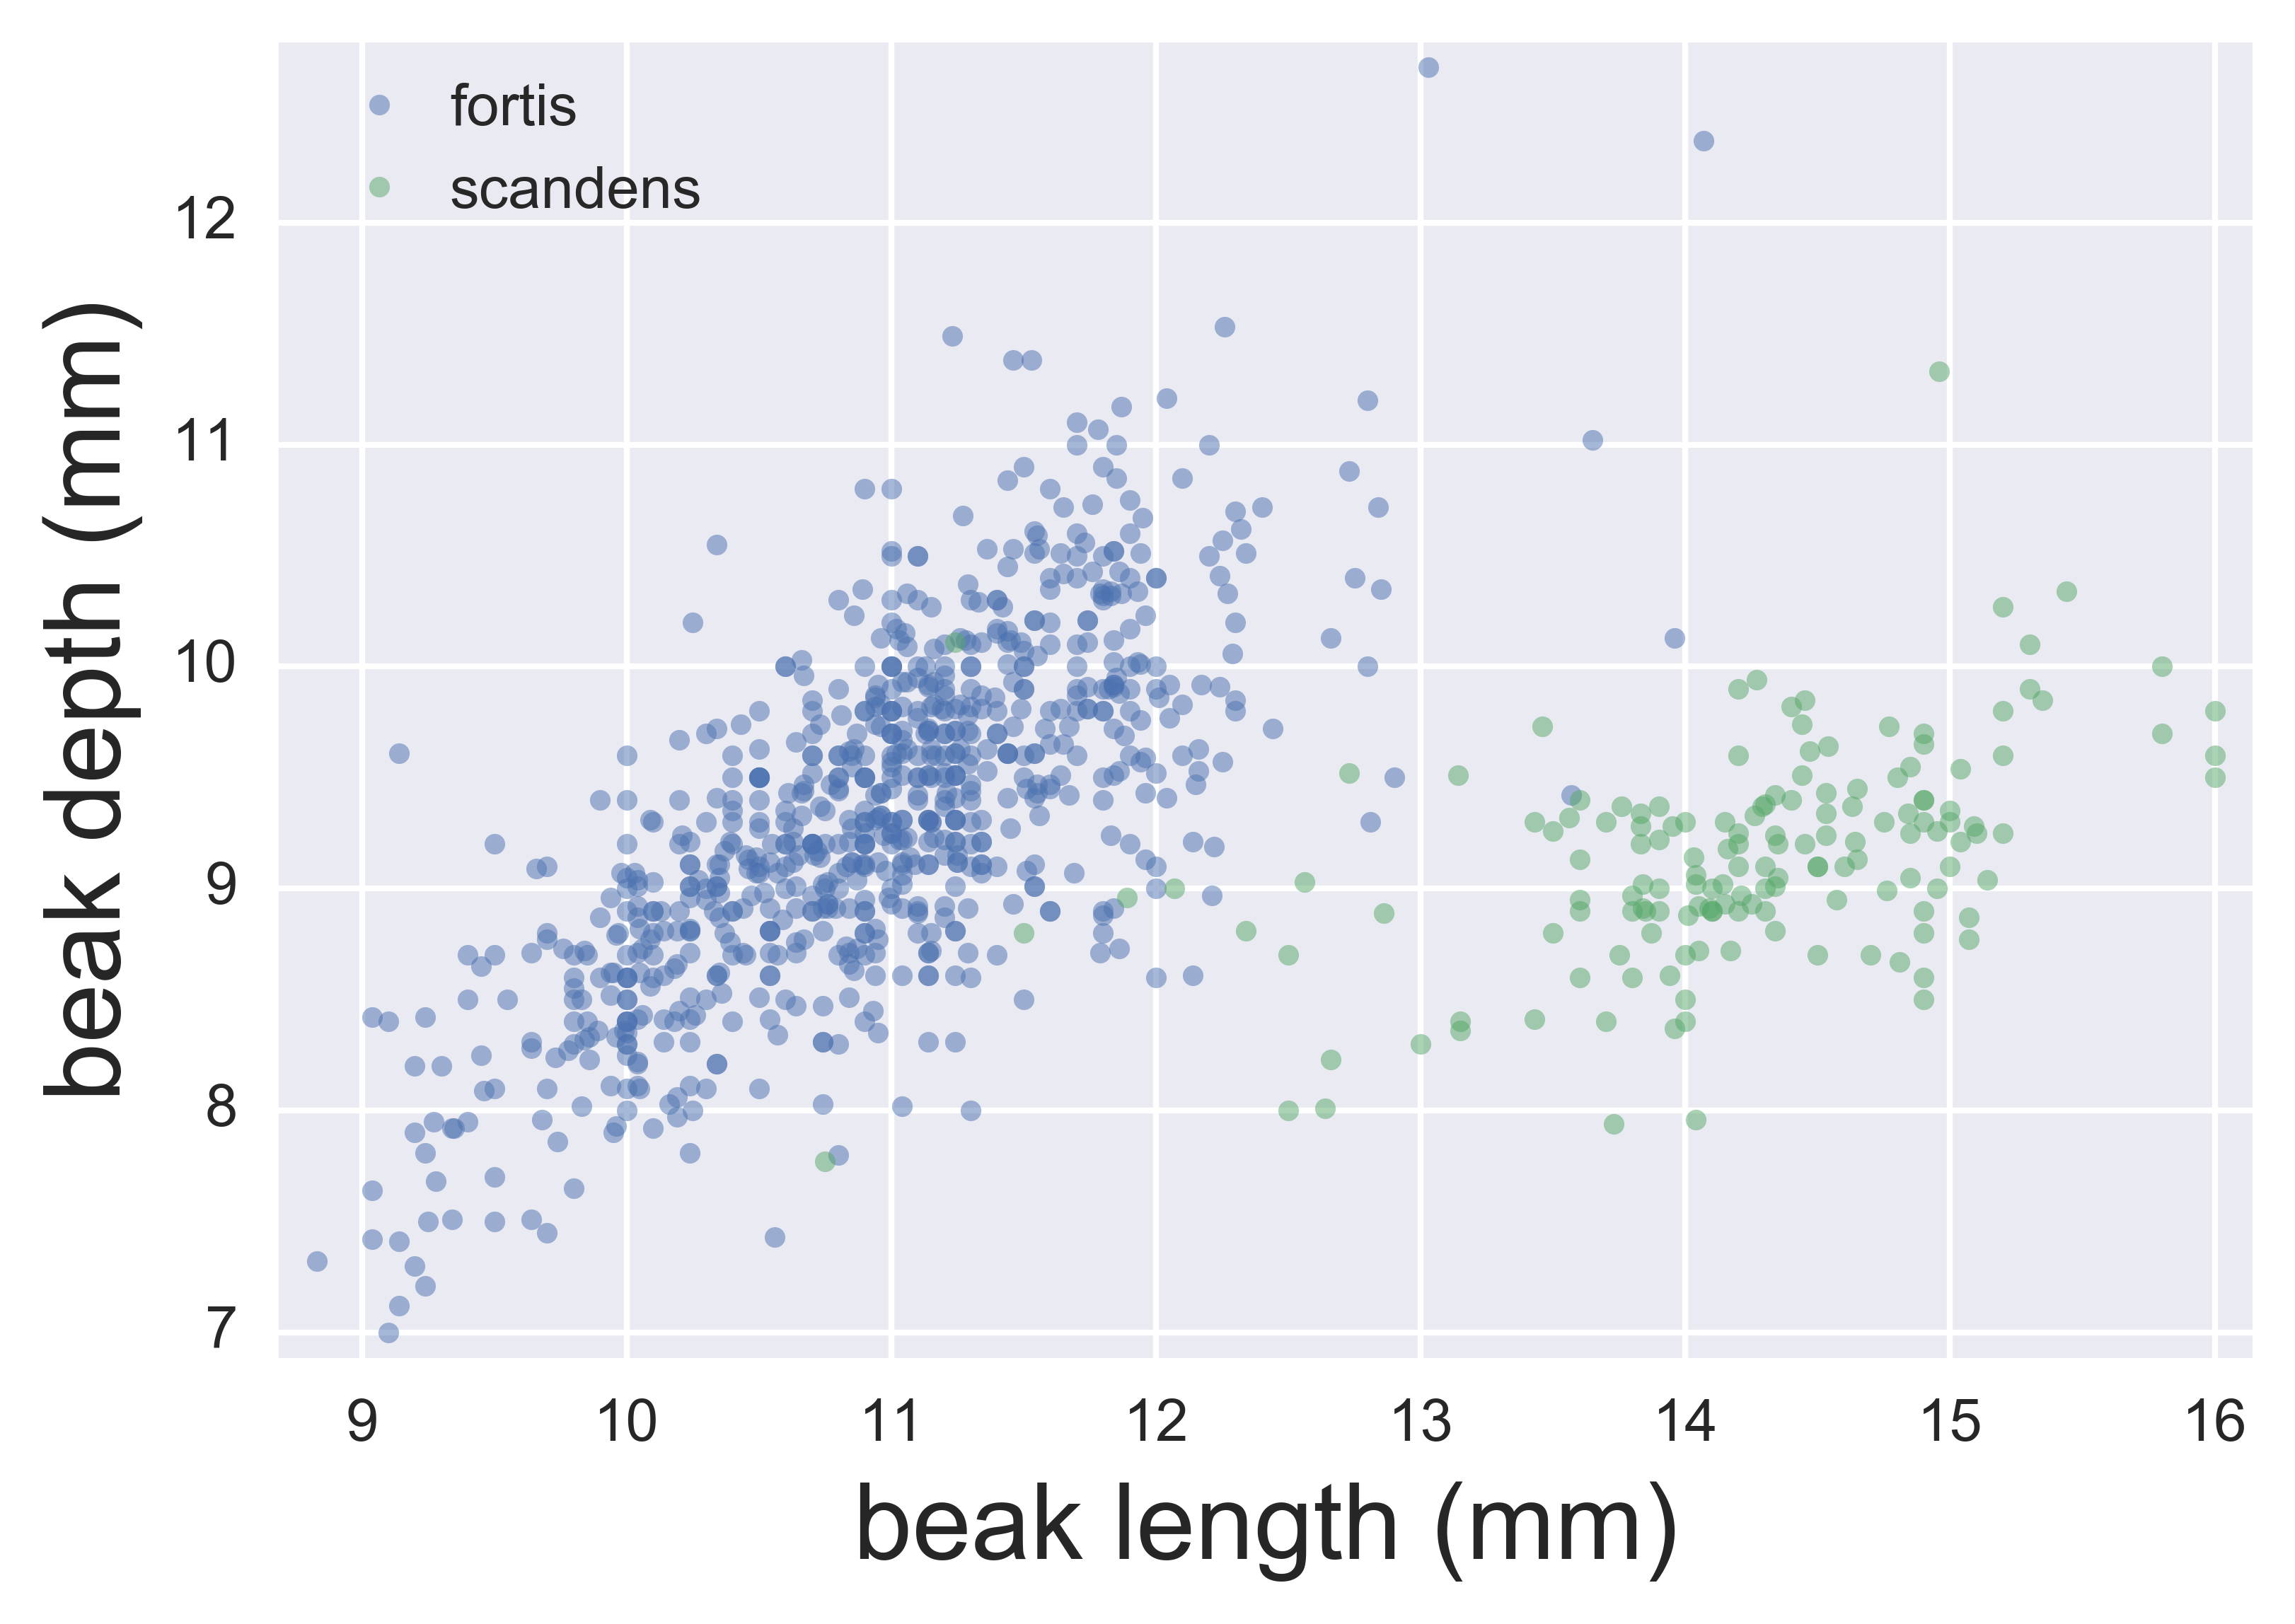

In [34]:
# Extract data we want
df_fortis = df[(df['year']==1987) & (df['species']=='fortis')]
df_scandens = df[(df['year']==1987) & (df['species']=='scandens')]

# Plot the result
plt.plot(df_fortis['beak length (mm)'], df_fortis['beak depth (mm)'],
         marker='.', linestyle='None', alpha=0.5)
plt.plot(df_scandens['beak length (mm)'], df_scandens['beak depth (mm)'],
         marker='.', linestyle='None', alpha=0.5)

# Clean up
plt.margins(0.02)
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(('fortis', 'scandens'), loc='upper left')

**f)** To generate all of the plots, we can loop through and generate a plot like we have above.  It is easiest to write a function to make the plot on a given set of axes.

In [35]:
def plot_beak_data(ax, df, year, legend=False):
    """
    Plot beak length and beak depth data for a given year
    on a given axis.
    """

    # Extract data we want
    df_fortis = df[(df['year']==year) & (df['species']=='fortis')]
    df_scandens = df[(df['year']==year) & (df['species']=='scandens')]


    # Plot the result
    ax.plot(df_fortis['beak length (mm)'], df_fortis['beak depth (mm)'],
            marker='.', linestyle='None', alpha=0.5)
    ax.plot(df_scandens['beak length (mm)'], df_scandens['beak depth (mm)'],
            marker='.', linestyle='None', alpha=0.5)

    # Clean up
    ax.margins(0.02)
    ax.set_xlabel('beak length (mm)', fontsize=12)
    ax.set_ylabel('beak depth (mm)', fontsize=12)
    ax.set_title(str(year), fontsize=14)
    if legend:
        ax.legend(('fortis', 'scandens'), loc='upper left')
    
    return ax

Now, we'll lay out a figure and make the plots.

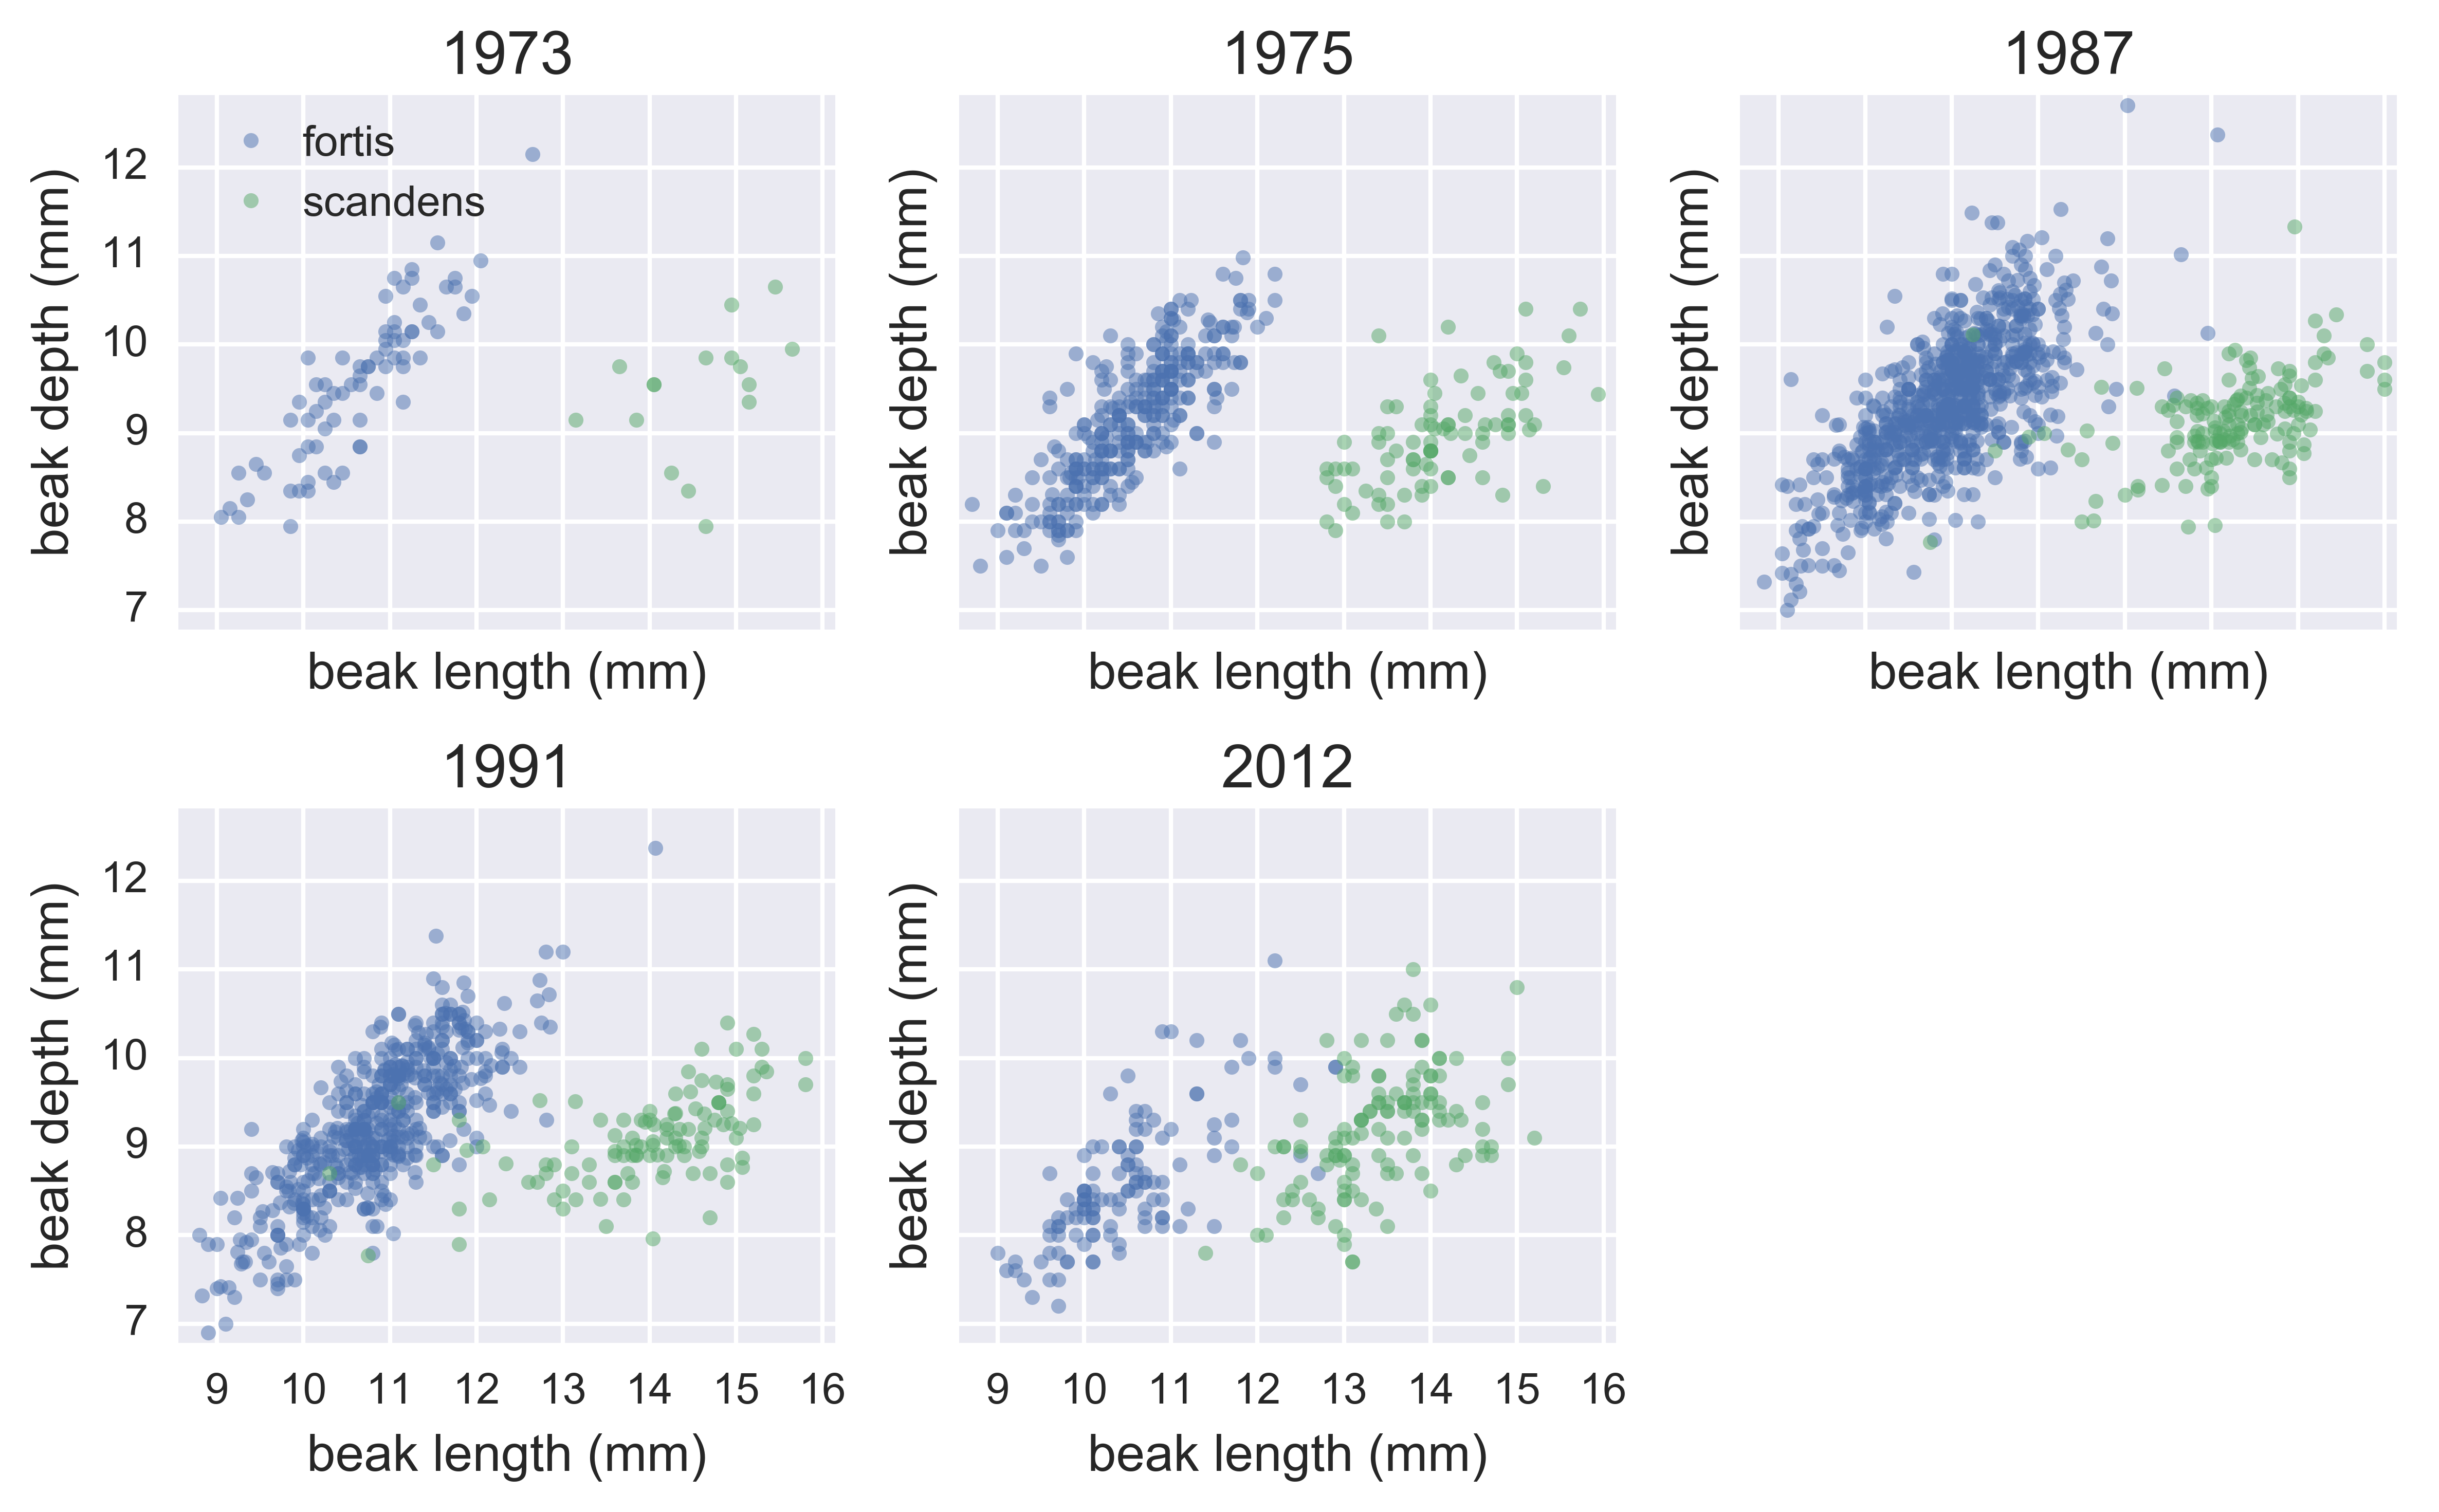

In [36]:
# Plots playout
fig, ax = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)

# Which axes to use
ax_inds = ((0,0), (0, 1), (0,2), (1,0), (1, 1))

# Loop through years and make plots
for i, year in enumerate(years):
    if i == 0:
        legend = True
    else:
        legend=False
        
    _ = plot_beak_data(ax[ax_inds[i]], df, year, legend=legend)
    
# Tidy up
ax[1, 2].axis('off')
fig.tight_layout()

When we look at the data this way, we see the the species coming together.

## Exercise 4.2: Hacker stats on bee sperm data

Neonicotinoid pesticides are thought to have inadvertent effects on service-providing insects such as bees. A recent study of this was recently [featured in the New York Times](http://www.nytimes.com/2016/07/29/science/neonicotinoid-insecticide-bee-sperm.html). The original paper is [Straub, et al.,  Proc. Royal Soc. B 283(1835): 20160506](http://dx.doi.org/10.1098/rspb.2016.0506). Straub and coworkers put their [data in the Dryad repository](http://dx.doi.org/10.5061/dryad.bs515), which means we can work with it!

(Do you see a trend here? If you want people to think deeply about your results, explore them, learn from them, in general further science with them, *make your data publicly available.* Strongly encourage the members of your lab to do the same.)

We will look at the weight of drones (male bees) using the data set stored in `~/git/bootcamp/data/bee_weight.csv` and the sperm quality of drone bees using the data set stored in `~/git/bootcamp/data/bee_sperm.csv`.

**a)** Load the drone weight data in as a Pandas `DataFrame`.  Note that the unit of the weight is milligrams (mg).

**b)** Plot ECDFs of the drone weight for control and also for those exposed to pesticide. Do you think there is a clear difference?

**c)** Compute the mean drone weight for control and those exposed to pesticide. Compute 95% bootstrap confidence intervals on the mean.

**d)** Repeat parts (a)-(c) for drone sperm. Use the `'Quality'` column as your measure. This is defined as the percent of sperm that are alive in a 500 µL sample.

**e)** As you have seen in your analysis in part (d), both the control and pesticide treatments have some outliers with very low sperm quality. This can tug heavily on the mean. So, get 95% bootstrap confidence intervals for the *median* sperm quality of the two treatments.

### Exercise 4.2: solution

**a)** After inspecting the data set, we see that the comments are given by `#`, and this is a standard CSV file.

In [37]:
df_weight = pd.read_csv('data/bee_weight.csv', comment='#')

**b)** To plot the ECDFs, we use our well-work ECDF function. We just select `Control` or `Pesticide` under the `Treatment` column.

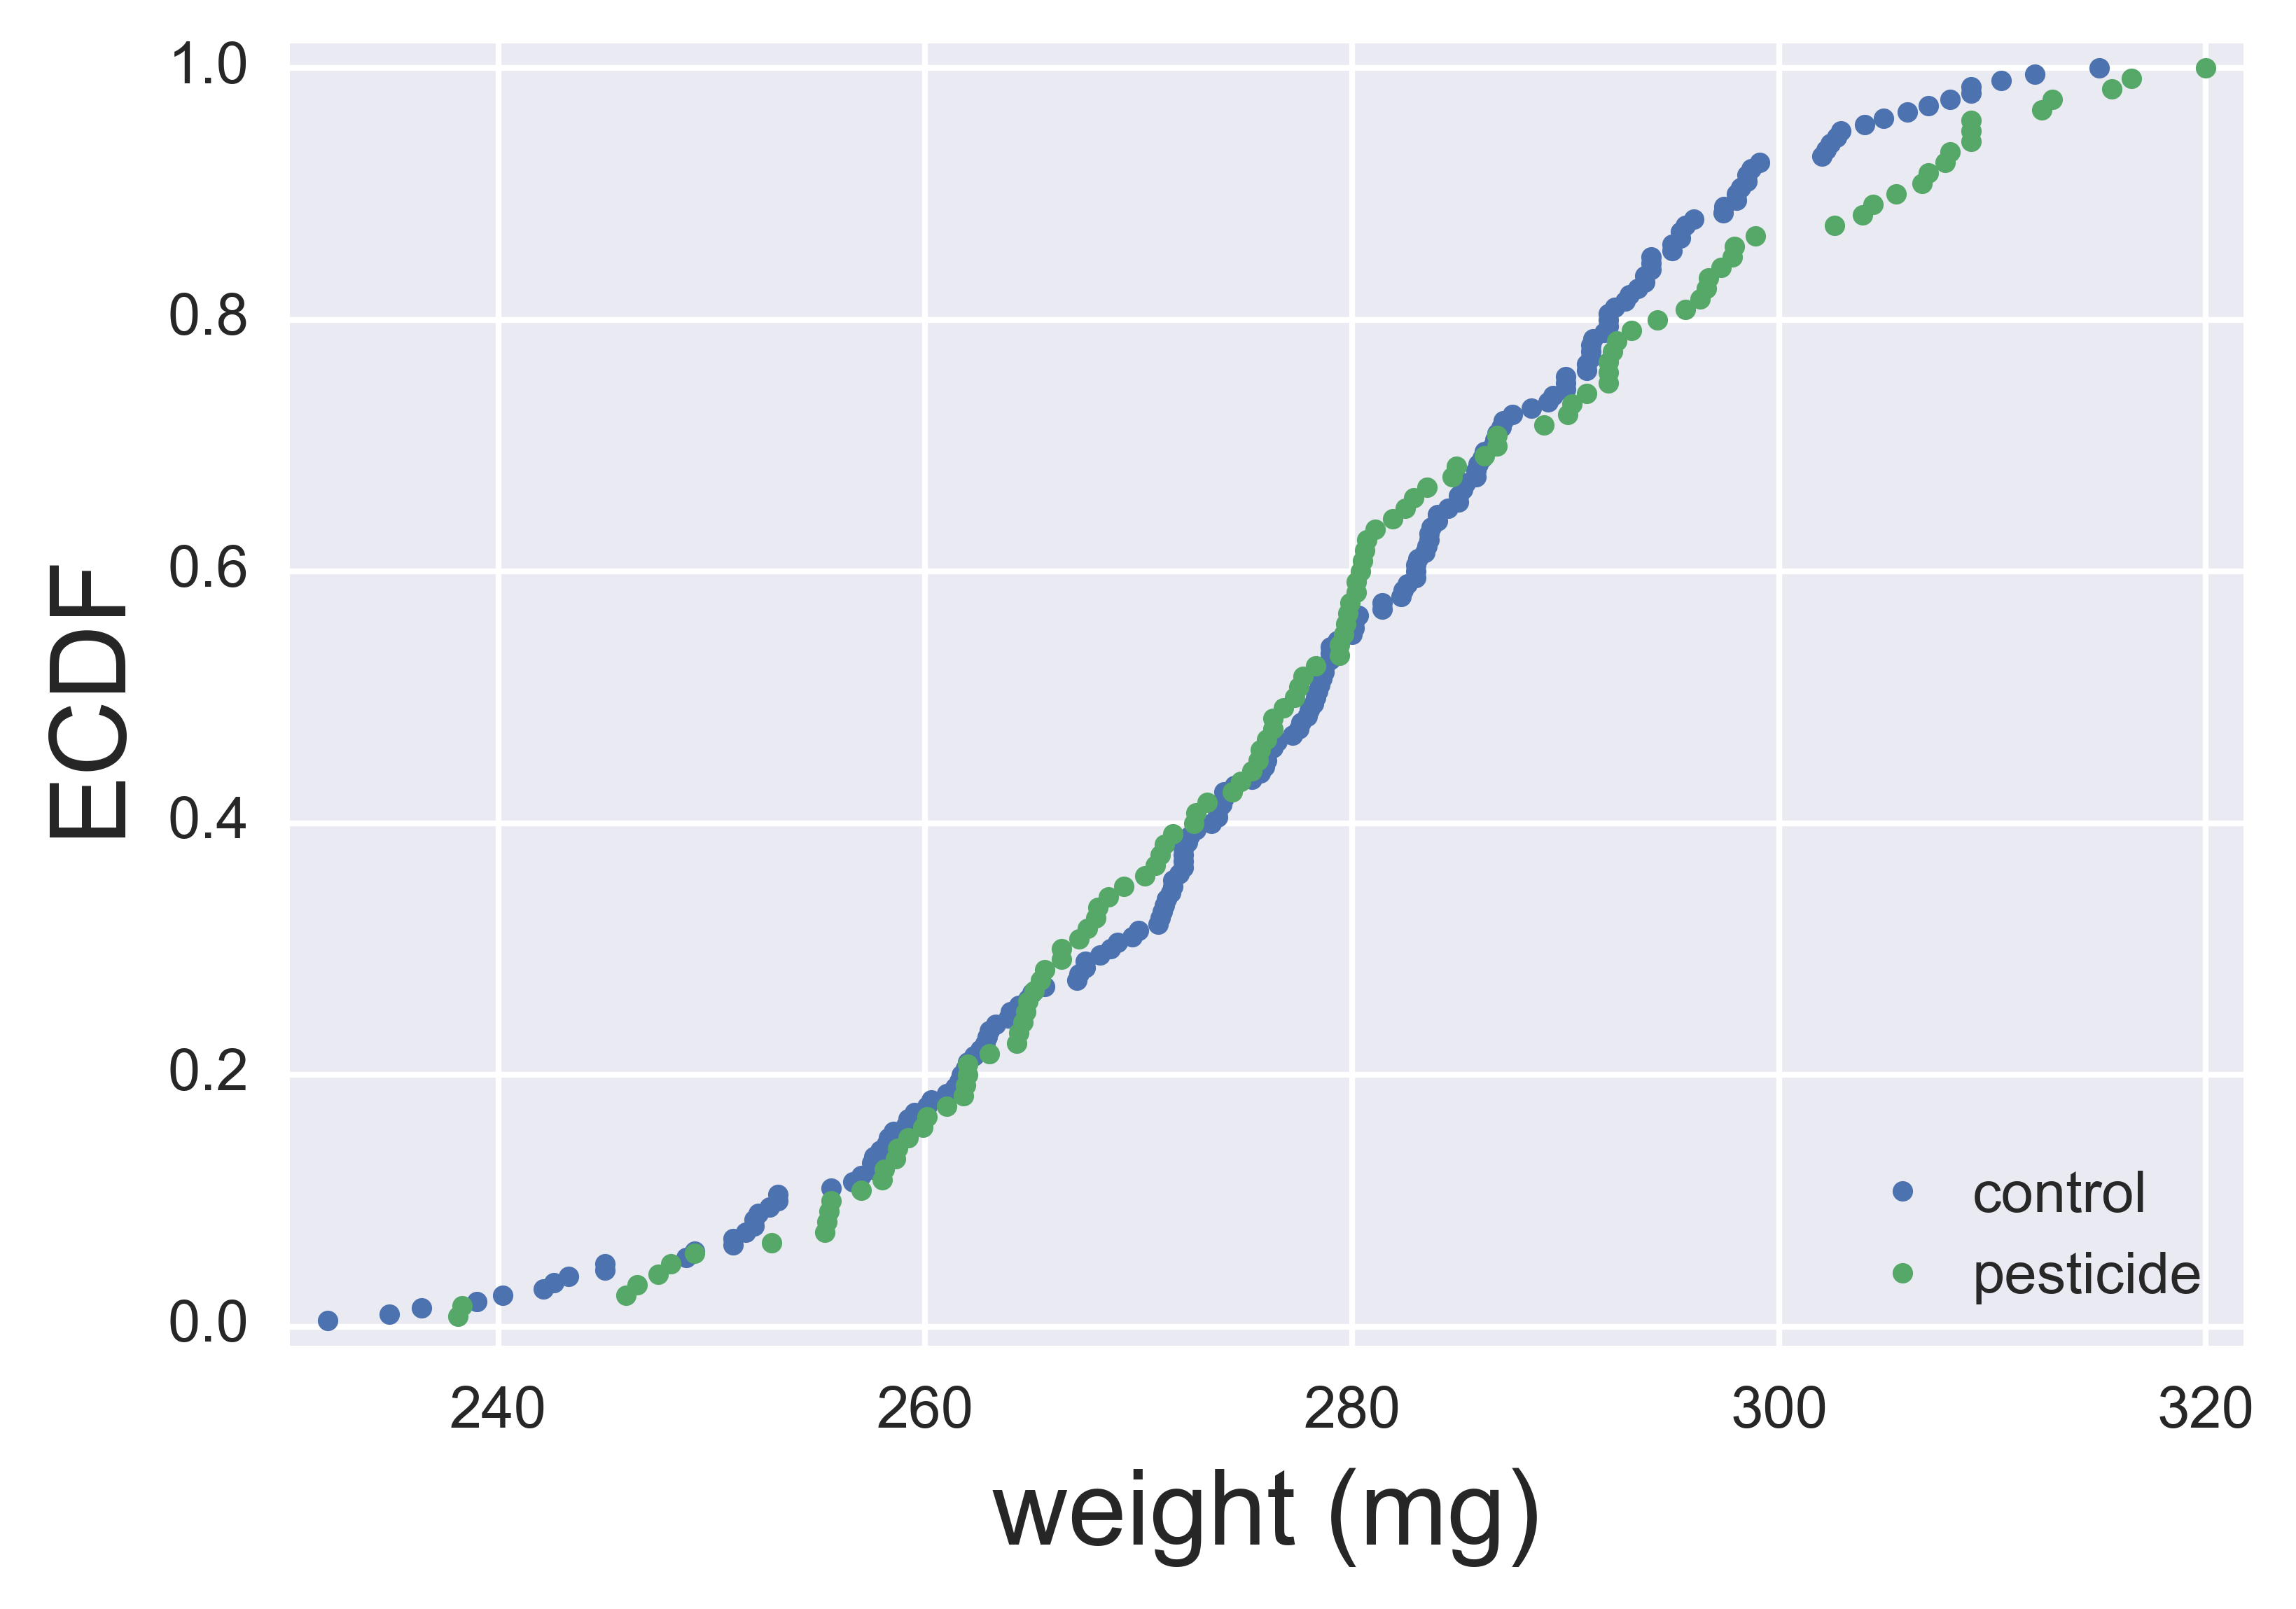

In [43]:
# Generate ECDFs
x_control, y_control = ecdf(df_weight.loc[df_weight['Treatment']=='Control',
                                        'Weight'])
x_pest, y_pest = ecdf(df_weight.loc[df_weight['Treatment']=='Pesticide', 
                                    'Weight'])

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('weight (mg)')
plt.ylabel('ECDF')
plt.legend(('control', 'pesticide'), loc='lower right')

The distributions look really similar. Now, let's compute confidence intervals on the mean weight of the drones.

**c)** First, we'll get point estimates for the mean weight under control and pesticide conditions.

In [46]:
mean_control = np.mean(df_weight.loc[df_weight['Treatment']=='Control', 'Weight'])
mean_pest = np.mean(df_weight.loc[df_weight['Treatment']=='Pesticide', 'Weight'])

print('Mean control:  ', mean_control, 'mg')
print('Mean pesticide:', mean_pest, 'mg')

Mean control:   277.0563 mg
Mean pesticide: 278.27333333333326 mg


The means are really close. Let's now compute the confidence intervals. We'll use the bootstrap replicate generating function we wrote in [Lesson 28](http://justinbois.github.io/bootcamp/2016/lessons/l28_practice_with_hackerstats_solution.html)

In [47]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates from a data set."""
    n = len(data)
    
    # Initialize array of replicates
    reps = np.empty(size)
    
    for i in range(size):
        # Generate bootstrap sample
        bs_sample = np.random.choice(data, n)
        
        # Compute replicate
        reps[i] = func(bs_sample)
        
    return reps

# Draw 100,000 bootstrap reps for both.
bs_reps_control = draw_bs_reps(
        df_weight.loc[df_weight['Treatment']=='Control', 'Weight'], np.mean, 
        size=100000)
bs_reps_pest = draw_bs_reps(
        df_weight.loc[df_weight['Treatment']=='Pesticide', 'Weight'], np.mean, 
        size=100000)

Now, we can use `np.percentile()` to compute the 95% confidence interval.

In [49]:
conf_int_control = np.percentile(bs_reps_control, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print('Confidence interval for control:', conf_int_control)
print('Confidence interval for pesticide:', conf_int_pest)

Confidence interval for control: [ 274.6835975  279.4100075]
Confidence interval for pesticide: [ 275.05664583  281.53416667]


They have nearly the same confidence interval, as we would expect from the ECDFs.

**d)** We just go through the same steps as before. First, the ECDF.

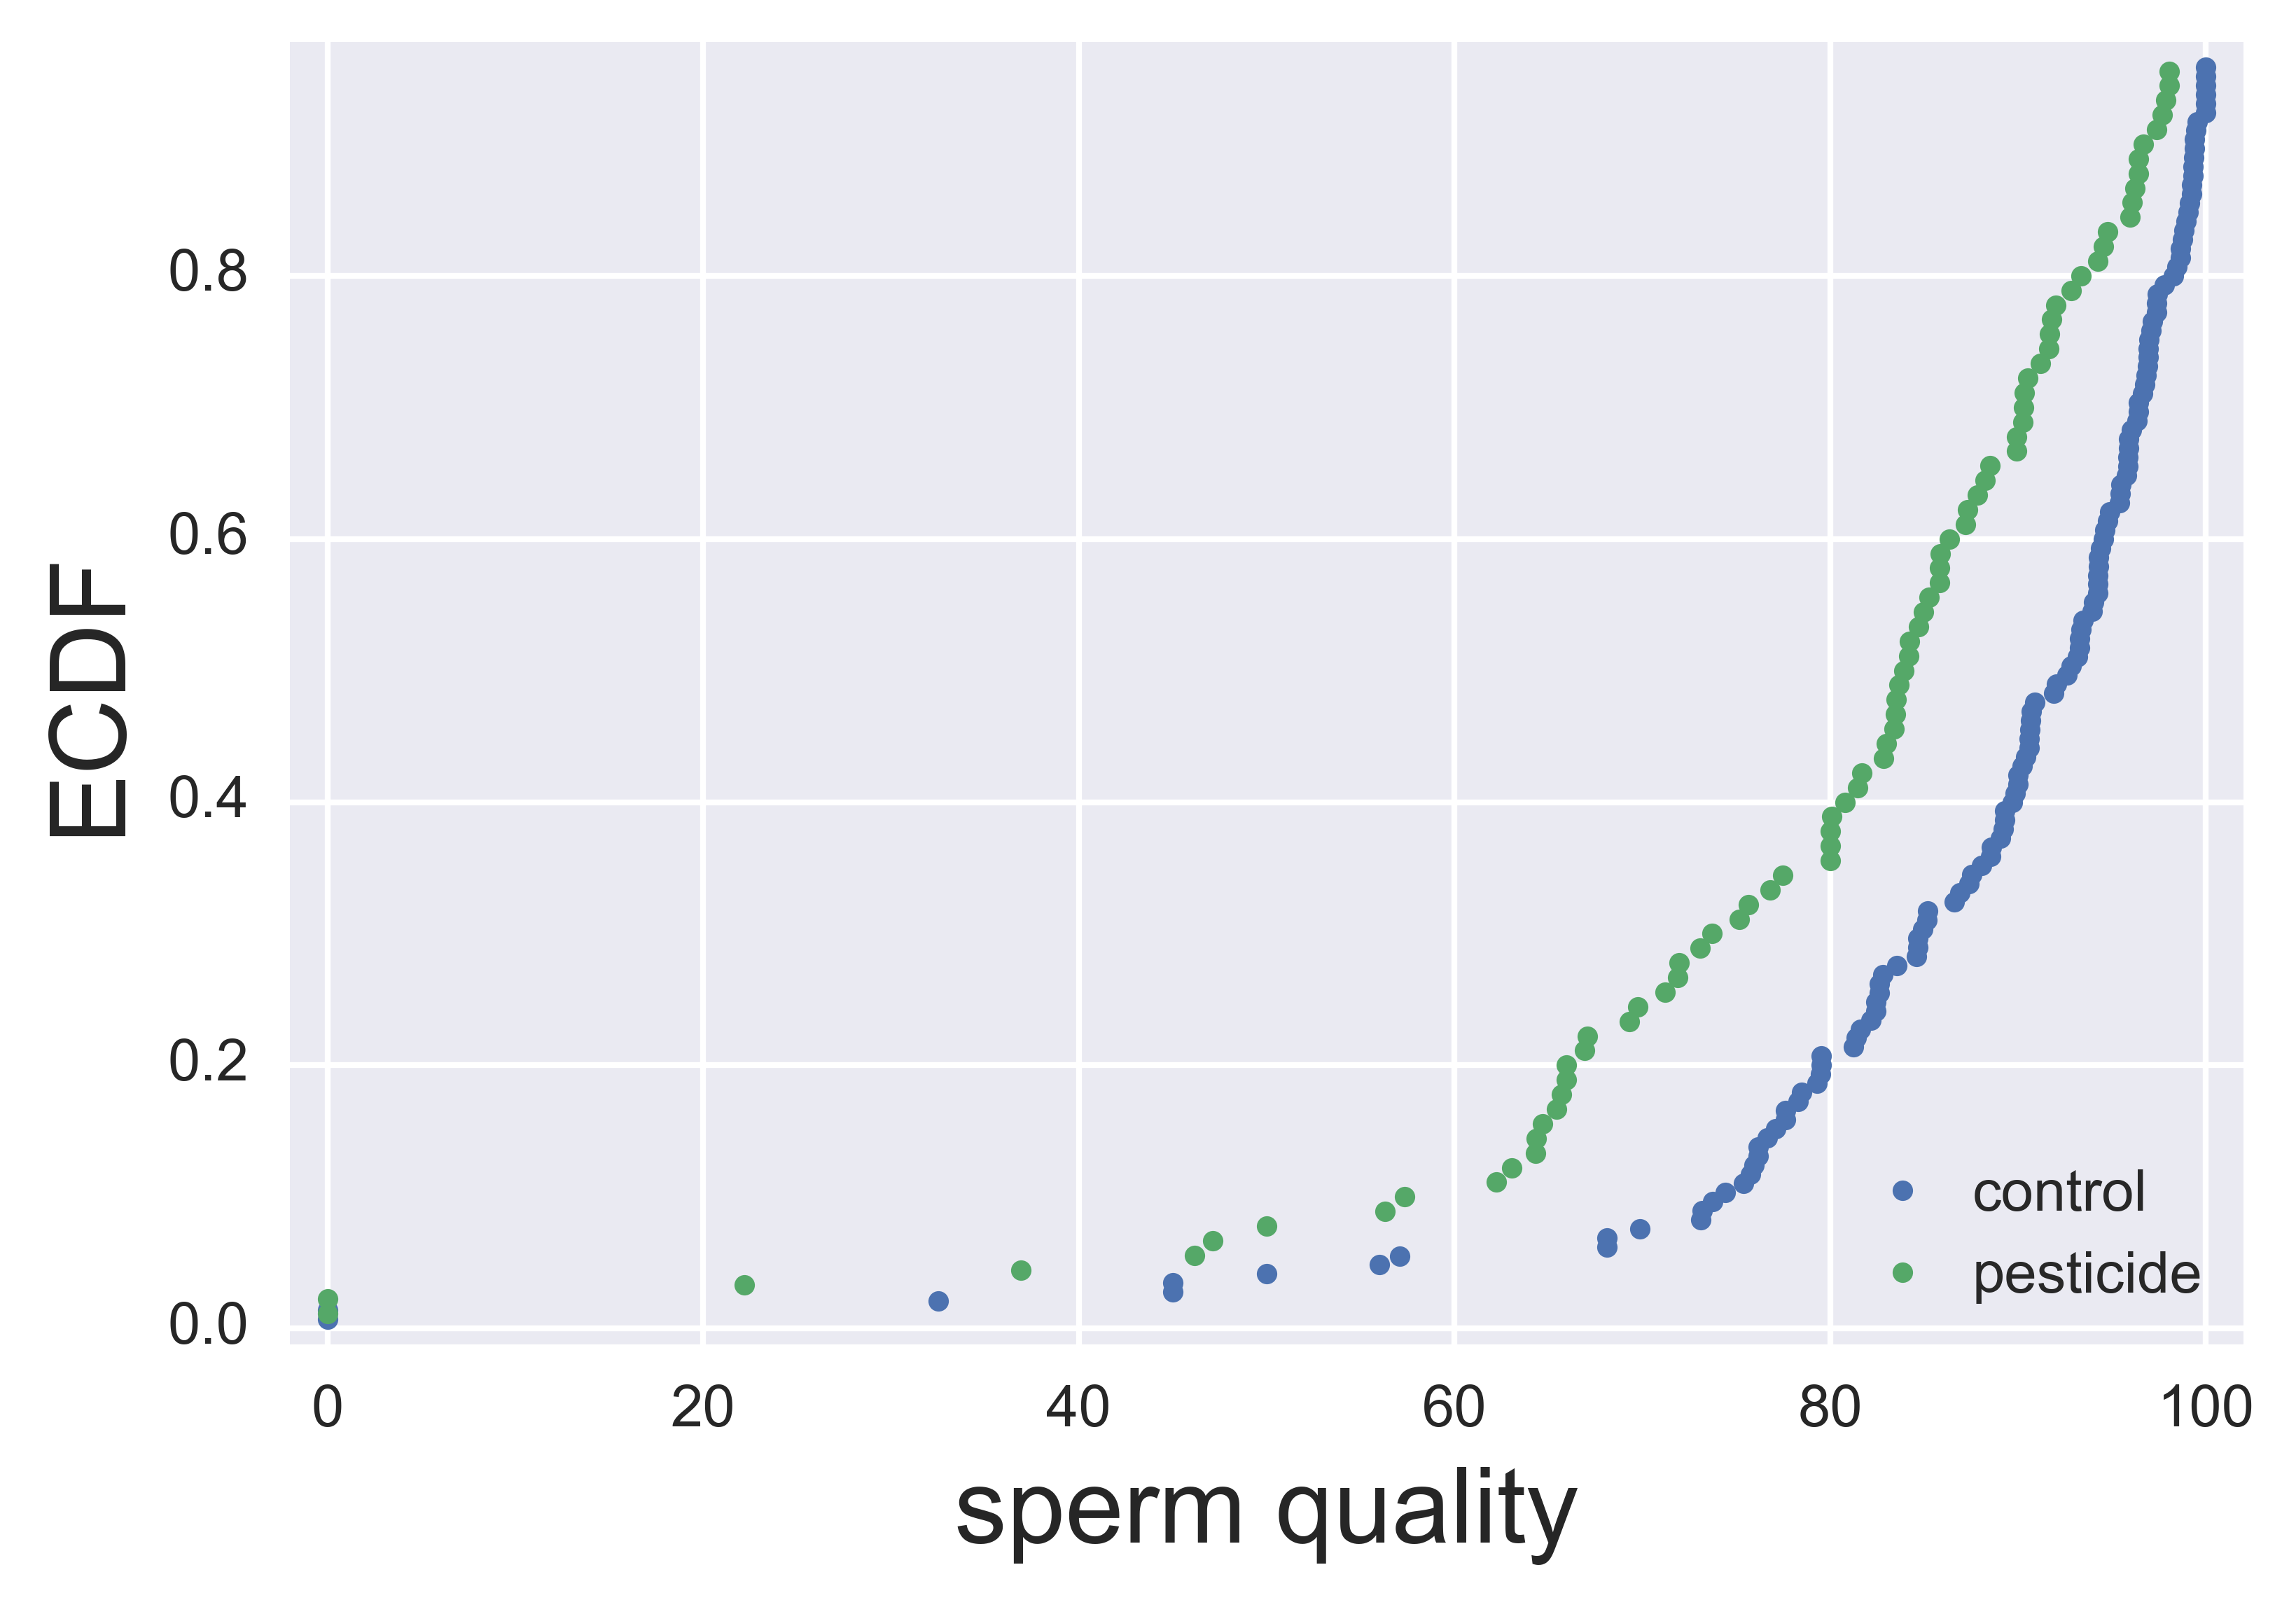

In [50]:
# Load data set
df_sperm = pd.read_csv('data/bee_sperm.csv', comment='#')

# Make ECDF
# Generate ECDFs
x_control, y_control = ecdf(df_sperm.loc[df_sperm['Treatment']=='Control',
                                         'Quality'])
x_pest, y_pest = ecdf(df_sperm.loc[df_sperm['Treatment']=='Pesticide', 
                                   'Quality'])

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('sperm quality')
plt.ylabel('ECDF')
plt.legend(('control', 'pesticide'), loc='lower right')

We have some very low quality samples from both, but it is pretty clear that on a while the pesticide samples have much lower sperm quality. Let's compute the confidence interval on the mean. We have to be careful, though, because there are some `NaN`s in the data set, so we have to use `dropna()`.

In [54]:
# Draw 100,000 bootstrap reps for both.
bs_reps_control = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Control', 'Quality'].dropna(),
        np.mean,size=100000)
bs_reps_pest = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Pesticide', 'Quality'].dropna(),
        np.mean, size=100000)

# Compute and print confidence interval
conf_int_control = np.percentile(bs_reps_control, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print('Confidence interval for control:', conf_int_control)
print('Confidence interval for pesticide:', conf_int_pest)

Confidence interval for control: [ 84.26201741  89.53141359]
Confidence interval for pesticide: [ 74.03986837  82.04852991]


The confidence intervals of the mean do not overlap, further confirming that the pesticide-tested drones have lower sperm quality.

**e)** Now, let's try bootstrapping the median. This is the same procedure as before, except we just put `np.median` for our function where we have `np.median`.

In [55]:
# Draw 100,000 bootstrap reps for both.
bs_reps_control = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Control', 'Quality'].dropna(),
        np.median,size=100000)
bs_reps_pest = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Pesticide', 'Quality'].dropna(),
        np.median, size=100000)

# Compute and print confidence interval
conf_int_control = np.percentile(bs_reps_control, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print('Confidence interval for control:', conf_int_control)
print('Confidence interval for pesticide:', conf_int_pest)

Confidence interval for control: [ 89.84848485  94.2353021 ]
Confidence interval for pesticide: [ 80.0560062   85.84421182]


Again, we see that the confidence intervals do not overlap. The median is of course higher than the mean, since the low-quality outliers are removed.

## Exercise 4.3: Monte Carlo simulation of transcriptional pausing

In this exercise, we will put random number generation to use and do a **Monte Carlo simulation**.  The term Monte Carlo simulation is a broad term describing techniques in which a large number of random numbers are generated to (approximately) calculate properties of probability distributions.  In many cases the analytical form of these distributions is not known, so Monte Carlo methods are a great way to learn about them.

Transcription, the process by which DNA is transcribed into RNA, is key process in the central dogma of molecular biology.  RNA polymerase (RNAP) is at the heart of this process.  This amazing machine glides along the DNA template, unzipping it internally, incorporating ribonucleotides at the front, and spitting RNA out the back.  Sometimes, though, the polymerase pauses and then backtracks, pushing the RNA transcript back out the front, as shown in the figure below, taken from Depken, et al., *Biophys. J.*, **96**, 2189-2193, 2009.

![Schematic of a pausing RNAP from Depken, et al., *Biophys. J.*, **96**, 2189-2193, 2009](rnap_pause.png)

To escape these backtracks, a cleavage enzyme called TFIIS cleaves the bit on RNA hanging out of the front, and the RNAP can then go about its merry way.

Researchers have long debated how these backtracks are governed.  Single molecule experiments can provide some much needed insight.  The groups of Carlos Bustamante, Steve Block, and Stephan Grill, among others, have investigated the dynamics of RNAP in the absence of TFIIS.  They can measure many individual backtracks and get statistics about how long the backtracks last.

One hypothesis is that the backtracks simply consist of diffusive-like motion along the DNA stand.  That is to say, the polymerase can move forward or backward along the strand with equal probability once it is paused.  This is a one-dimensional **random walk**.  So, if we want to test this hypothesis, we would want to know how much time we should expect the RNAP to be in a backtrack so that we could compare to experiment.

So, we seek the probability distribution of backtrack times, $P(t_{bt})$, where $t_{bt}$ is the time spent in the backtrack.  We could solve this analytically, which requires some sophisticated mathematics.  But, because we know how to draw random numbers, we can just compute this distribution directly using Monte Carlo simulation!

We start at $x = 0$ at time $t = 0$. We "flip a coin," or choose a random number to decide whether we step left or right. We do this again and again, keeping track of how many steps we take and what the $x$ position is. As soon as $x$ becomes positive, we have existed the backtrack.  The total time for a backtrack is then $\tau n_\mathrm{steps}$, where $\tau$ is the time it takes to make a step.  Depken, et al., report that $\tau \approx 0.5$ seconds.

**a)** Write a function, `backtrack_steps()`, that computes the number of steps it takes for a random walker (i.e., polymerase) starting at position $x = 0$ to get to position $x = +1$. It should return the number of steps to take the walk.

**b)** Generate 10,000 of these backtracks in order to get enough samples out of $P(t_\mathrm{bt})$. (If you are interested in a way to really speed up this calculation, ask me about [Numba](http://numba.pydata.org).)

**c)** Use `plt.hist()` to plot a histogram of the backtrack times. Use the `normed=True` kwarg so it approximates a probability distribution function.

**d)** You saw some craziness in part (c). That is because, while most backtracks are short, some are reeeally long. So, instead, generate an ECDF of your samples and plot the ECDF with the $x$ axis on a logarithmic scale.

**e)** A probability distribution function that obeys a power law has the property

\begin{align}
P(t_\mathrm{bt}) \propto t_\mathrm{bt}^{-a}
\end{align}

in some part of the distribution, usually for large $t_\mathrm{bt}$. If this is the case, the cumulative distribution is then

\begin{align}
\mathrm{cdf}(t_\mathrm{bt}) \equiv F(t_\mathrm{bt})= \int_{-\infty}^{t_\mathrm{bt}} \mathrm{d}t_\mathrm{bt}'\,P(t_\mathrm{bt}') = 1 - \frac{c}{t_\mathrm{bt}^{a+1}}, \\
\phantom{blah}
\end{align}

where $c$ is some constant defined by the functional form of $P(t_\mathrm{bt})$ for small $t_\mathrm{bt}$ and the normalization condition.  If $F$ is our cumulative histogram, we can check for power law behavior by plotting the complementary cumulative distribution (CCDF), $1 - F$, versus $t_\mathrm{bt}$.  If a power law is in play, the plot will be linear on a log-log scale with a slope of $-a+1$.

Plot the complementary cumulative distribution function from your samples on a log-log plot. If it is linear, then the time to exit a backtrack is a power law.

**f)**
By doing some mathematical heavy lifting, we know that, in the limit of large $t_{bt}$,

\begin{align}
P(t_{bt}) \propto t^{-3/2},
\end{align}

so the plot you did in part (e) should have a slope of $-1/2$ on a log-log plot. Is this what you see?

**Notes:** The theory to derive the probability distribution is involved.  See, e.g., [this](https://en.wikipedia.org/wiki/First-hitting-time_model).  However, we were able to predict that we would see a great many short backtracks, and then see some very very long backtracks because of the power law distribution of backtrack times.  We were able to do that just by doing a simple Monte Carlo simulation.  There are many problem where the theory is *really* hard, and deriving the distribution is currently impossible, or the probability distribution has such an ugly expression that we can't really work with it.  So, Monte Carlo methods are a powerful tool for generating predictions from simply-stated, but mathematically challenging, hypotheses.

Interestingly, many researchers thought (and maybe still do) there were two classes of backtracks: long and short.  There may be, but the hypothesis that the backtrack is a random walk process is commensurate with seeing both very long and very short backtracks.

**a)** For speed, I will use Numba to compile the function. You can read more about Numba [here](http://numba.pydata.org/). For now, though, you can just ignore the `@numba.jit()` decorator on the function.

In [57]:
@numba.jit(nopython=True)
def backtrack_steps():
    """
    Compute the number of steps it takes a 1d random walker starting
    at zero to get to +1.
    """

    # Initialize position and number of steps
    x = 0
    n_steps = 0
    
    # Walk until we get to positive 1
    while x < 1:
        x += 2 * np.random.randint(0, 2) - 1
        n_steps += 1
    
    return n_steps

**b)** Now let's run it lots and lots of time. We will convert the result to time using the fact that each step takes about half a second.

In [60]:
# Stepping time
tau = 0.5 # seconds

# Specify number of samples
n_samples = 10000

# Array of backtrack times
t_bt = np.empty(n_samples)

# Generate the samples
for i in range(n_samples):
    t_bt[i] = backtrack_steps()
    
# Convert to seconds
t_bt *= tau

**c)** Now, let's plot a histogram of our backtrack times. We'll use 100 bins.

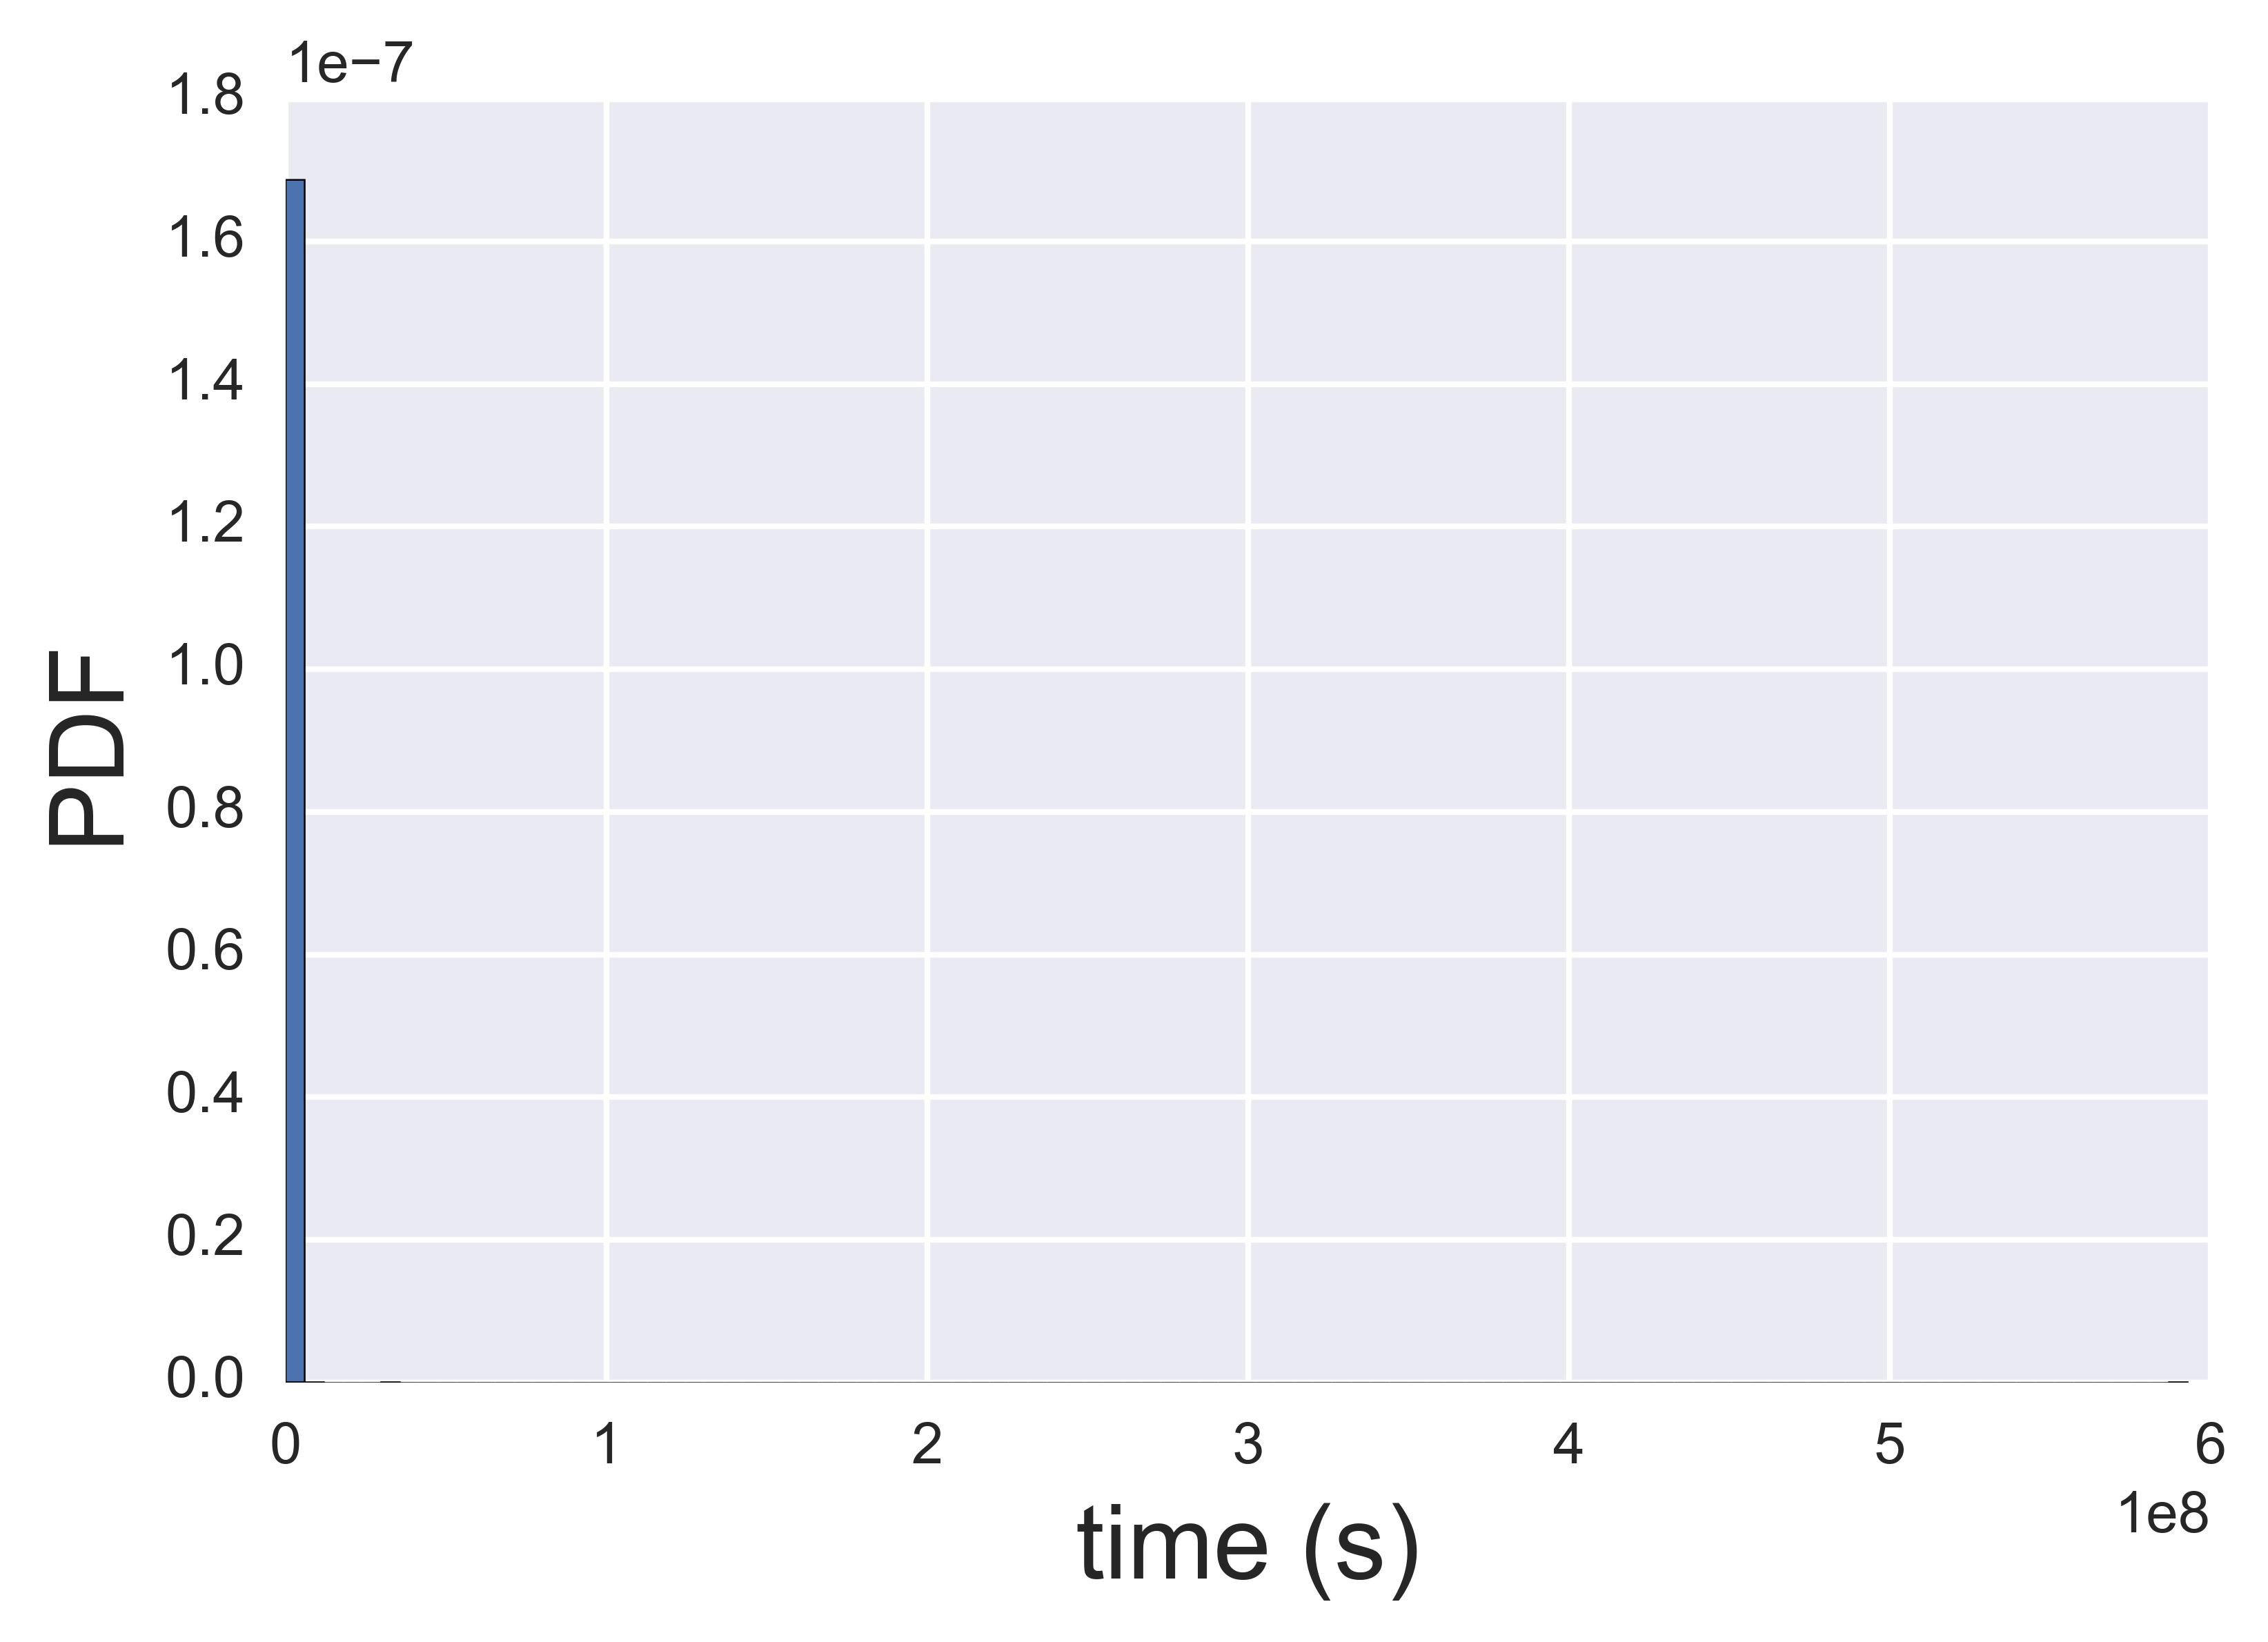

In [63]:
_ = plt.hist(t_bt, bins=100, normed=True)
plt.xlabel('time (s)')
plt.ylabel('PDF')

**d)** Yeesh! Good suggestion, JB, let's plot the ECDF.

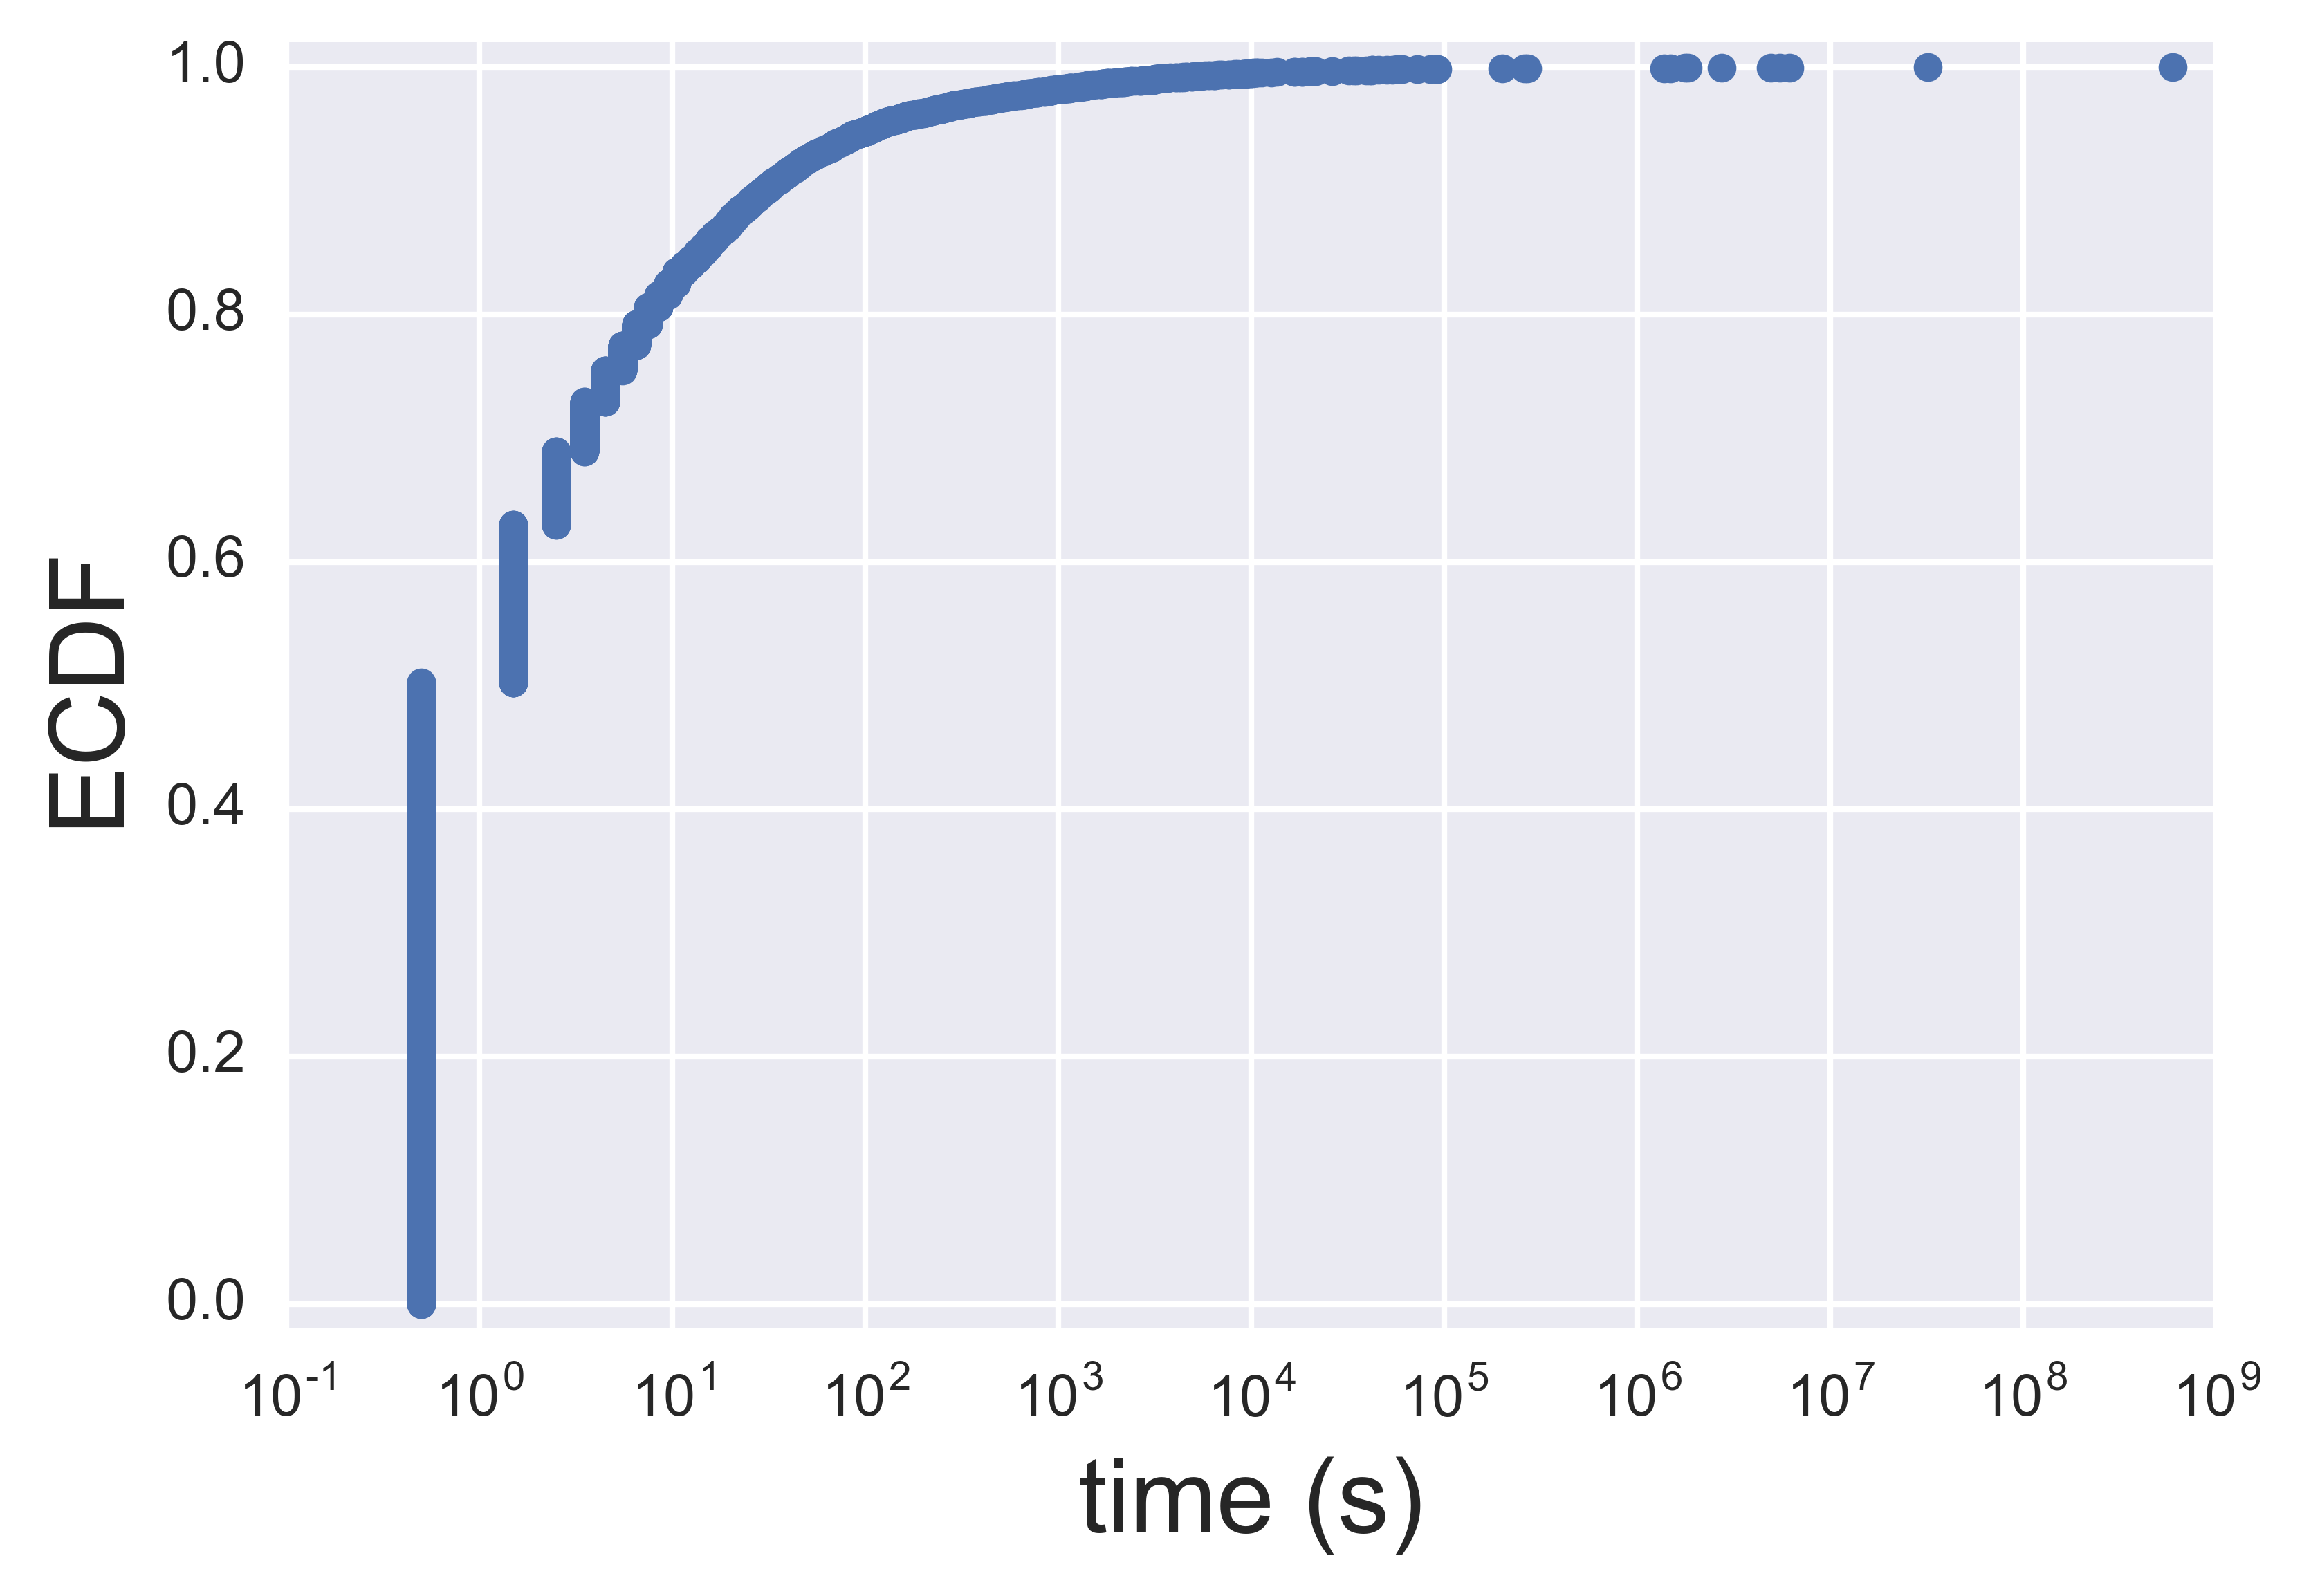

In [66]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Generate x, y values
x, y = ecdf(t_bt)

# Plot CDF from random numbers
plt.semilogx(x, y, '.', markersize=10)

# Clean up plot
plt.margins(y=0.02)
plt.xlabel('time (s)')
plt.ylabel('ECDF')

This makes more sense. We see that half of all backtracks end immediately, with the first step being rightward. It is impossible to leave a backtrack in an even number of steps, so there are no two-step escapes. Then, we get a lot of 3-step escapes, and so on. But this goes more and more slowly. Yes, 80% of backtracks only last 10 seconds, but there are still many extraordinarily long backtracks. These are the fundamental predictions of our hypothesis. Of cource $10^7$ seconds is 115 days, which is obviously much longer than a backtrack could physically last.

**e, f)** Now, let's plot the CCDF along with a theoretical power law line.

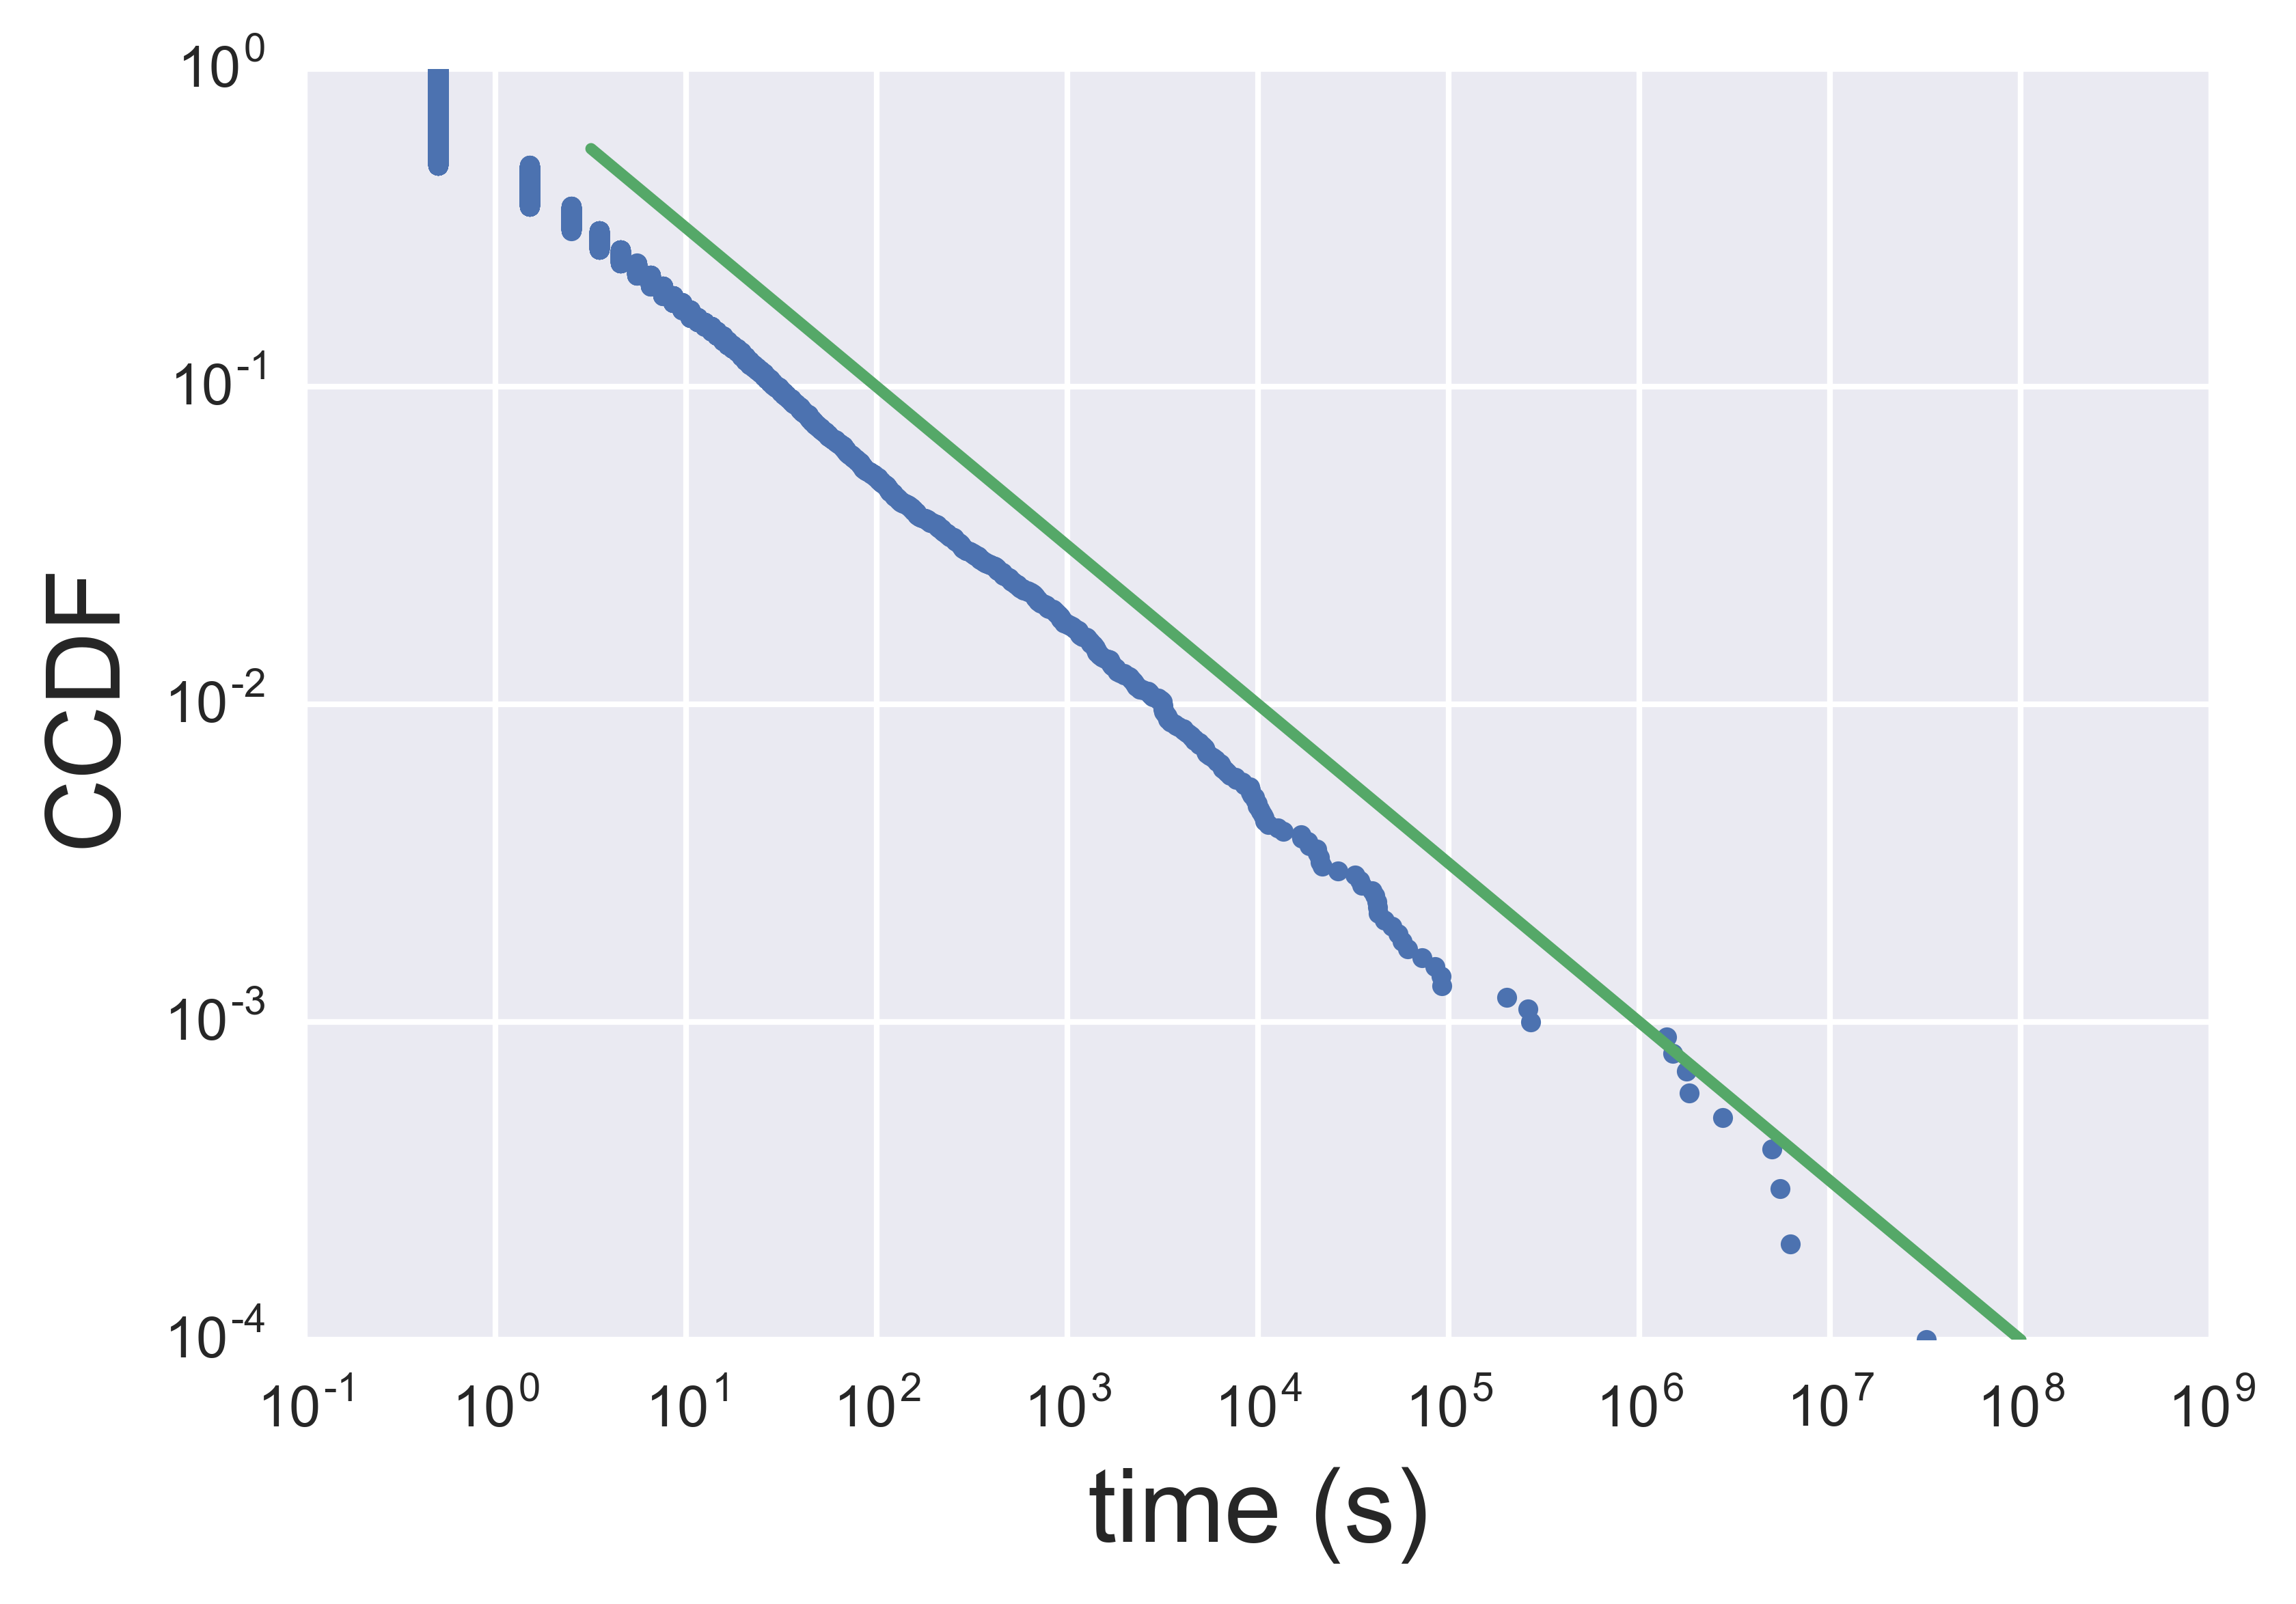

In [67]:
# Plot the CCDF
plt.loglog(x, 1 - y, '.')

# Plot the asymptotic power law
t_smooth = np.logspace(0.5, 8, 100)
plt.loglog(t_smooth, 1 / np.sqrt(t_smooth))

# Label axes
plt.xlabel('time (s)')
plt.ylabel('CCDF')

Indeed, we see that the slope we got from Monte Carlo simulation matches what the theory predicts.